# Overview

This Jupyter notebook accompanies the manuscript of Cox et al. titled “Observing low-oxygen-adapted phytoplankton in the eastern tropical North Pacific using a Biogeochemical Argo float”. It is designed to illustrate how the model is fitted to data from a BGC-Argo float (WMO 3901531) in the eastern tropical North Pacific using Python coding language.

Please note that this example is designed such that each cell (block of Python code) is run after the previous cell. If you clear or restart, you will need to run through each cell from the start. 

## Data

A full description of the data from the BGC-Argo float and how it is processed is provided in the manuscript.

## Model

A full description of the model and how it is tuned to the data is provided in the manuscript.

## Define functions for notebook

In [1]:
# Fit Kd to PAR
def fcn2min_Kd(params1, X1, Y1):
    G1 = params1['G1']
    G2 = params1['G2']
    model = G1+(-G2)*X
    return(model-Y1)   

# Define function for Community 1, 2, and 3 normalised Chl-a
def fcn2min_2pop(params2, X, Y):
    P1 = params2['P1']
    P2 = params2['P2']
    P3 = params2['P3'] # maximum biomass (normalised) 
    P4 = params2['P4'] # psuedo parameter controlling depth of maximum biomas (P3)
    P5 = params2['P5'] # width of peak
    P6 = params2['P6'] # maximum biomass (normalised) 
    P7 = params2['P7'] # psuedo parameter controlling depth of maximum biomas (P3)
    P8 = params2['P8'] # width of peak
    MLD_pop = 1 - 1./(1+np.exp(-(P1/P2)*(Y-P2)))
    DCM_pop = P3*np.exp(-((Y - P4)/(P5))**2.) + P6*np.exp(-((Y-P7)/P8)**2)
    model = MLD_pop + DCM_pop
    return(model-X)

# Define bbp function for Community 1, 2 and 3 normalised bbp
def fcn3min_bbp_norm(params1, X1, A1, A2, A3):
    #Input parameters
    P1 = params1['P1']
    P2 = params1['P2']
    P3 = params1['P3']
    model   = (1.-P3)*A1 + P1*A2 + P2*A3 + P3
    return(model-X1)

## Load packages needed for notebook

In [2]:
import numpy as np
import numpy.ma as ma
import math as mt
import julian
import datetime
import scipy
import matplotlib as mpl
import matplotlib.ticker as tick
import netCDF4 as nc
import pandas as pd
import scipy.integrate as spi
import seawater as sw # Import CSIRO seawater package
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import nan
from netCDF4 import Dataset
from matplotlib import pyplot as plt 
from matplotlib.colors import LogNorm
from scipy import interpolate
from scipy import signal
from numpy import exp, sin
from scipy.optimize import leastsq
from lmfit import Minimizer, Parameters, report_fit
from suntime import Sun, SunTimeException
from holteandtalley import HolteAndTalley
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats
from scipy.stats import pearsonr
# Supresses outputs when trying to "divide by zero" or "divide by NaN" or "treatment for floating-point overflow"
#np.seterr(divide='ignore', over='ignore', invalid='ignore');
np.seterr(all='ignore');

## Load BGC Argo float (WMO 3901531)

S-prof netCDF file extracted from ftp://ftp.ifremer.fr/ifremer/argo/dac/bodc/ on 15/06/2022

In [3]:
#WMO number
FLOAT_NUMBER = '3901531'

#Read the BGC-Argo netCDF file into Python
BGC_DATA     = FLOAT_NUMBER+'_Sprof.nc'
fh           = Dataset(BGC_DATA, mode='r')

#Read key information on the float
PROJECT_NAME  = fh.variables['PROJECT_NAME'][:]
PI_NAME       = fh.variables['PI_NAME'][:]
PLATFORM_TYPE = fh.variables['PLATFORM_TYPE'][:]
CYCLE_NUMBER  = fh.variables['CYCLE_NUMBER'][:]
TYPE_DATA  = fh.variables['PARAMETER_DATA_MODE'][:]
fh.close()

#Print key information
print('Project Name =', str(PROJECT_NAME[0].tobytes(), 'utf-8'))
print('PI Name =', str(PI_NAME[0].tobytes(), 'utf-8'))
print('Platform Type =', str(PLATFORM_TYPE[0].tobytes(), 'utf-8'))
print('Maximum Cycle Number =', str(np.max(CYCLE_NUMBER)))

Project Name = Uk-Bioargo                                                      
PI Name = Giorgio Dall'Olmo                                               
Platform Type = PROVOR_III                      
Maximum Cycle Number = 342


## Read variables from float and compute other properties for all profiles
- READ IN DATA FROM FLOAT
- CONVERT TIME TO DATETIME 
- COMPUTATION OF DAILY INTEGRATED PAR 
- COMPUTATION OF DEPTH, DENSITY AND BRUNT–VäISäLä USING SEAWATER PACKAGE
- COMPUTATION OF MIXED LAYER DEPTH 
- COMPUTATION OF KD(PAR), EUPHOTIC DEPTH (Zp), 1ST OPTICAL DEPTH, SURFACE CHL-A AND BBP
- COMPUTATION OF 5 DOXY (MICRO MOL kg$^{-3}$) DEPTH

### NB: this can take time to run as mixed layer depth code is computationally expensive!

In [4]:
#Read time and locations of profiles 
fh           = Dataset(BGC_DATA, mode='r')
JULD         = fh.variables['JULD'][:]            #Julian day of the profile.
LONGITUDE    = fh.variables['LONGITUDE'][:]       #Longitude degrees East
LATITUDE     = fh.variables['LATITUDE'][:]        #Latitude degress North

#Read netCDF CORE ARGO
PRESSURE     = fh.variables['PRES'][:]            #Pressure (Dbar) we assume equivalent to depth (m)
TEMP         = fh.variables['TEMP'][:]            #Temperature (degress C)
PSAL         = fh.variables['PSAL'][:]            #Salinity (PSU)

#Read netCDF BGC ARGO ADJUSTED (s-profile)
CHLA         = fh.variables['CHLA_ADJUSTED'][:]   #Chlorophyll-a 
BBP          = fh.variables['BBP700'][:]          #Backscattering at 700nm (m^-1)
DISS_OXY     = fh.variables['DOXY'][:]            #Dissolved Oxygen (micro mole kg^-3)
PAR          = fh.variables['DOWNWELLING_PAR'][:] #Downwelling PAR 
fh.close()

#Convert time from Julian day to Year-Month-Day T HOUR:MINUTE:SECOND
REFERENCE_DATE = 2433282.50000  #JULIAN DATE for reference 1950-01-01 00:00:00
TIME_BGC       = np.empty(len(JULD), dtype='datetime64[s]')
MONTH_BGC      = np.empty(len(JULD), dtype='datetime64[s]')
for i in range(len(JULD)):
    TIME_BGC[i] = julian.from_jd(JULD[i]+REFERENCE_DATE, fmt='jd')

#Scale PAR to daily integral
Sun_rise = np.empty(len(JULD), dtype='datetime64[s]')
Sun_set  = np.empty(len(JULD), dtype='datetime64[s]')
for i in range(len(JULD)):
    sun = Sun(LATITUDE[i], LONGITUDE[i])
    Sun_rise[i] = sun.get_sunrise_time(pd.to_datetime(TIME_BGC[i]))
    Sun_set[i]  = sun.get_sunset_time(pd.to_datetime(TIME_BGC[i])) 
DH_TIME_BGC    = pd.DatetimeIndex(TIME_BGC, dtype='datetime64[ns]', name='date_time', freq=None)
DH_TIME_BGC    = DH_TIME_BGC.hour + DH_TIME_BGC.minute / 60
DH_SUNRISE     = pd.DatetimeIndex(Sun_rise, dtype='datetime64[ns]', name='date_time', freq=None)
DH_SUNRISE     = DH_SUNRISE.hour + DH_SUNRISE.minute / 60
DH_SUNSET      = pd.DatetimeIndex(Sun_set, dtype='datetime64[ns]', name='date_time', freq=None)
DH_SUNSET      = DH_SUNSET.hour + DH_SUNSET.minute / 60
DH_DAYLEN      = DH_SUNSET - DH_SUNRISE
#Nan PAR data collected before sunrise and after sunset
INDEX = np.empty([len(JULD)])+nan
SCALE_TIME_BGC = DH_TIME_BGC - DH_SUNRISE
AFTER_TIME_BGC = DH_SUNSET - DH_TIME_BGC
ads = np.where(SCALE_TIME_BGC > 0.)
INDEX[ads] = 1.0
ads = np.where(AFTER_TIME_BGC < 0.)
INDEX[ads] = 1.0
DH_DAYLEN = DH_DAYLEN*(60*60.)#convert hours to senconds
SCALE_TIME_BGC = SCALE_TIME_BGC*(60*60.)#convert hours to senconds
#Loop nan PAR data collected before sunrise and after sunset convert PAR to daily integral
NOON_PAR       = PRESSURE*0
DAY_PAR        = PRESSURE*0
for i in range(len(JULD)):
    if np.isnan(INDEX[i]):
        PAR[i,:]      = PAR[i,:]*nan
        NOON_PAR[i,:] = PAR[i,:]*nan
        DAY_PAR[i,:]  = PAR[i,:]*nan
    else:
        NOON_PAR[i,:] = PAR[i,:]/ np.sin((np.pi*SCALE_TIME_BGC[i])/DH_DAYLEN[i])
        DAY_PAR[i,:]  = ((NOON_PAR[i,:]*2.*DH_DAYLEN[i])/np.pi)/1000000. #convert to Einstein
PAR = DAY_PAR

#Compute absolute depth and denisty from seawater package
DEPTH     = PRESSURE*0
DENSITY   = PRESSURE*0
for i in range(len(JULD)):
    DEPTH[i,:]   = sw.dpth(PRESSURE[i,:], LATITUDE[i]) # use "sw.dpth" function to calculate depth from pressure
    DENSITY[i,:] = sw.dens0(PSAL[i,:], TEMP[i,:]) 

#Compute Brunt–Väisälä (buoyancy) frequency
BRUNT = PRESSURE*nan
for i in range(len(JULD)):
    BRUNT_T    = sw.bfrq(PSAL[i,:], TEMP[i,:], PRESSURE[i,:], LATITUDE[i])
    BRUNT_T1   = BRUNT_T[0]
    BRUNT_T1   = np.resize(BRUNT_T1, len(BRUNT_T1))
    BRUNT_T3   = BRUNT_T[2]
    BRUNT_T3   = np.resize(BRUNT_T3, len(BRUNT_T3))   
    PRES_T     = PRESSURE[i,:]
    valid1     = np.logical_not(ma.getmask(PRES_T))
    PRES_T1    = PRES_T.compressed()
    interpfunc = interpolate.interp1d(BRUNT_T3,BRUNT_T1, kind='linear',fill_value="extrapolate")
    xxx        = interpfunc(PRES_T1)
    BRUNT[i,valid1] = xxx  

## Compute mixed layerdepth Holt and Tally MLD https://github.com/garrettdreyfus/python-holteandtalley
MLD_TEMP_ARRAY = np.empty(len(JULD))+nan
for i in range(len(JULD)):
    A = PRESSURE[i,:]
    B = TEMP[i,:]
    valid1 = np.logical_not(ma.getmask(A))
    A      = A[valid1]
    B      = B[valid1]
    valid1 = np.logical_not(ma.getmask(B))
    A      = A[valid1]
    B      = B[valid1]
    if len(A) > 100:
        h = HolteAndTalley(A,B)
        ##The temperature algorithms mixed layer depth
        MLD_TEMP_ARRAY[i] = h.tempMLD   

# Compute Kd
Kd_fit       = np.empty(len(JULD))*nan
G1           = np.empty(len(JULD))*nan
Surf_CHL     = np.empty(len(JULD))*nan
Surf_BBP     = np.empty(len(JULD))*nan
#Loop through each profile (float cycle)
for i in range(len(JULD)):
    #Fit Kd
    Y = PAR[i,:]
    X = PRESSURE[i,:]
    valid1 = np.logical_not(ma.getmask(Y))
    X = X[valid1]
    Y = Y[valid1]
    valid2 = np.logical_not(ma.getmask(X))
    X = X[valid2]
    Y = Y[valid2]
    idx = np.where(X <= 200)
    X = X[idx]
    Y = Y[idx]
    idx = np.where(Y >= 0)
    X = X[idx]
    Y = Y[idx]
    Y1 = np.log(Y)
    X1 = X
    #Need at least 10 measurmeents in top 200m
    if len(X1) > 10:
        params1 = Parameters()
        params1.add('G1', value=4)
        params1.add('G2', value=0.05)
        out = Minimizer(fcn2min_Kd, params1, fcn_args=(X1, Y1))
        result = out.minimize()
        G1_FIT = result.params['G1'].value
        G2_FIT = result.params['G2'].value
        if G2_FIT >= 0.04:
            Kd_fit[i] = G2_FIT
            G1[i] = G1_FIT
        else:
            Kd_fit[i] = nan
            G1[i] = nan
    #Get surface Chl and bbp
    idx = np.where(PRESSURE[i,:] <= 1.0/Kd_fit[i])
    Surf_CHL[i] = np.mean(CHLA[i,idx])
    Surf_BBP[i] = np.mean(BBP[i,idx])

#Compute Euphotic depth and 1st Optical Depth
Zp = 4.6/Kd_fit
OD = 1.0/Kd_fit

# Compute DOXY 1 DEPTH
DOXY_1_DEPTH       = np.empty(len(JULD))*nan
DEPTH_1DOXY        = [22]
#Loop through each profile (float cycle)
for i in range(len(JULD)):
    Y = DISS_OXY[i,:]
    X = DEPTH[i,:]
    valid1 = np.logical_not(ma.getmask(Y))
    X = X[valid1]
    Y = Y[valid1]
    valid2 = np.logical_not(ma.getmask(X))
    X = X[valid2]
    Y = Y[valid2]
    if len(X) > 10:
        asd = np.where(Y <= 5.)
        ads = asd[0]
        DOXY_1_DEPTH[i]    = X[ads[0]]
    else:
        DOXY_1_DEPTH[i]    = nan

/var/folders/sg/d693qhj52lq8p0_kw1644p2m0000gp/T/ipykernel_15649/3197597810.py:31: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  Sun_rise[i] = sun.get_sunrise_time(pd.to_datetime(TIME_BGC[i]))
/var/folders/sg/d693qhj52lq8p0_kw1644p2m0000gp/T/ipykernel_15649/3197597810.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  Sun_set[i]  = sun.get_sunset_time(pd.to_datetime(TIME_BGC[i]))
/var/folders/sg/d693qhj52lq8p0_kw1644p2m0000gp/T/ipykernel_15649/3197597810.py:142: UserWarning: Warning: converting a masked element to nan.
  Surf_CHL[i] = np.mean(CHLA[i,idx])
/var/folders/sg/d693qhj52lq8p0_kw1644p2m0000gp/T/ipykernel_15649/3197597810.py:143: UserWarning: Warning: converting a masked element to nan.
  Surf_BBP[i] = np.mean(BBP[i,idx])


## Plot map of float trajectory (Figure 1 of paper)

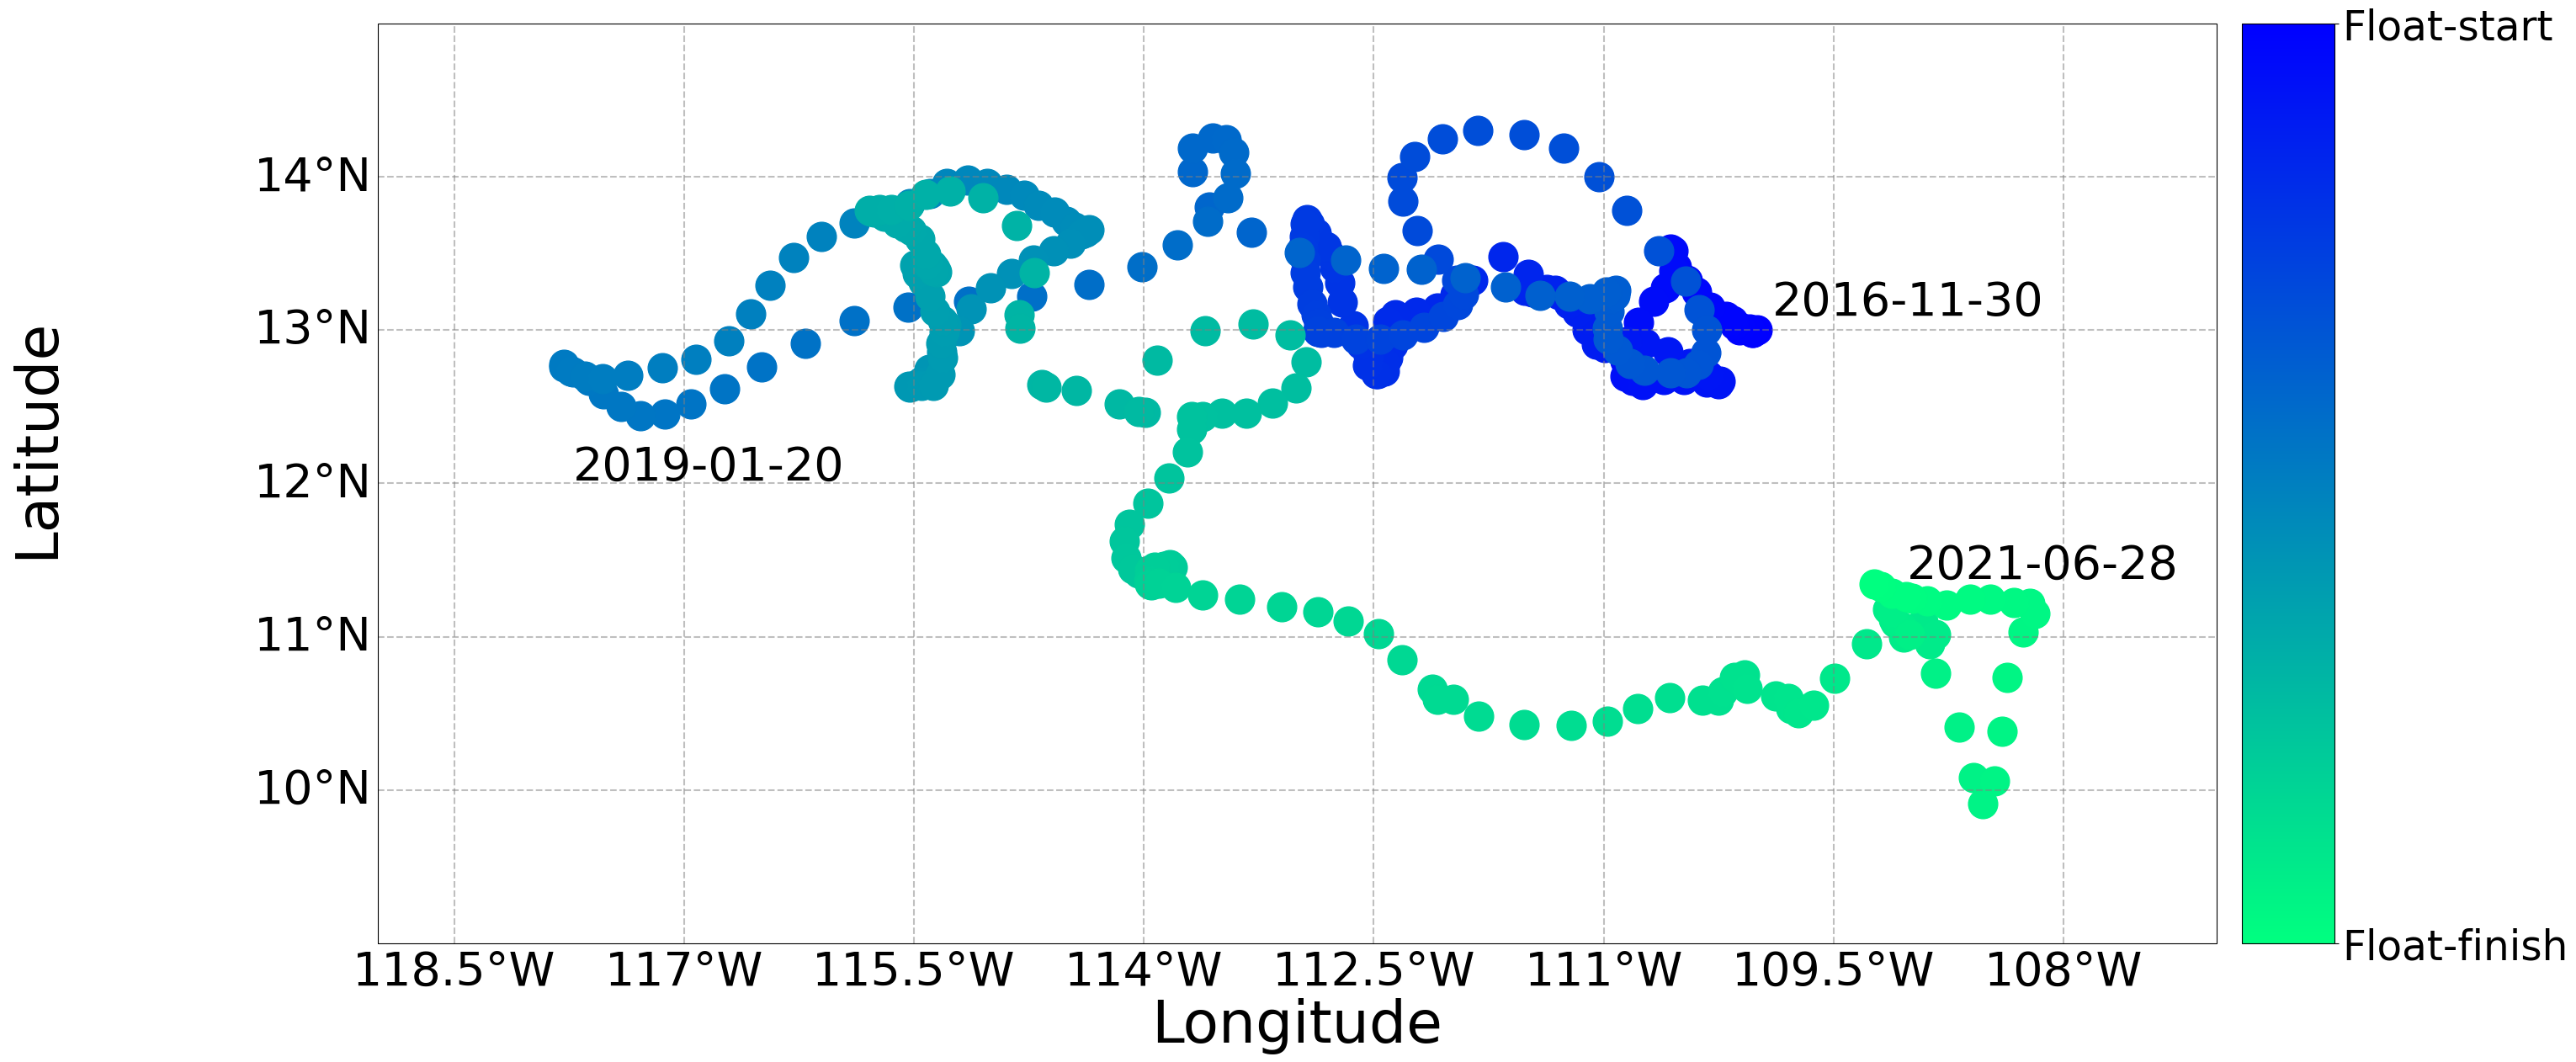

In [5]:
#Figure parameters that can be changed
XSIZE           = 30               #Define the xsize of the figure window
YSIZE           = 20               #Define the ysize of the figure window
Title_font_size = 15               #Define the font size of the titles
Label_font_size = 12               #Define the font size of the labels
cmap            = mpl.cm.winter    #Defines the colour scale 
cmap2           = mpl.cm.winter_r  #Defines the colour scale

# initialise figure
fig = plt.figure(figsize=(XSIZE,YSIZE))
fig.patch.set_facecolor('White')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=35))
transform = ccrs.PlateCarree()._as_mpl_transform(ax)

#Loop thorugh profiles and colour according to time
dates = [pd.to_datetime(d) for d in TIME_BGC]

for i in range(len(JULD)):
    ax.plot(LONGITUDE[i],LATITUDE[i], color = cmap(i / float(len(JULD))), marker='o', markersize=25, transform=ccrs.PlateCarree())

#1st profile    
ax.annotate(dates[0].strftime("%Y-%m-%d"), 
            xy=(LONGITUDE[0]+0.1,LATITUDE[0]+0.1),
            xycoords=transform, fontsize=40)
#164 profile    
ax.annotate(dates[163].strftime("%Y-%m-%d"), 
            xy=(LONGITUDE[163],LATITUDE[163]-0.7),
            xycoords=transform, fontsize=40)
#Last profile    
ax.annotate(dates[341].strftime("%Y-%m-%d"), 
            xy=(LONGITUDE[341]+0.1,LATITUDE[341]+0.1),
            xycoords=transform, fontsize=40)       
lbl_color = 'k'

# set geographical extent of figure
ax.set_extent([-119, -107, 9, 15], ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'fontsize': 40, 'color': lbl_color}
gl.xlabel_style = {'fontsize': 40, 'color': lbl_color}
ax.text(-0.17, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=50)
ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=50)

# plot colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.3, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap2), cax=ax_cb, ticks=[0, 1])
cb.ax.set_yticklabels(['Float-finish','Float-start'], fontsize=35)

#Complete the plot
plt.show()

## Clean the data
- CONVERT MASKED ARRAY TO NOMRAL ARRAY, NANS FOR MISSING DATA
- REMOVE PROFILES WITHOUT KD
- REMOVE PROFILES WITHOUT SURFACE CHL and SURFACE CHL <0.01
- REMOVE PROFILES WITHOUT AT LEAST 10 MEASURMENTS IN TOP 300m OF CHL

In [6]:
#Fill masked array with NAN
PRESSURE        = ma.filled(PRESSURE, fill_value = np.nan)
TEMP            = ma.filled(TEMP, fill_value = np.nan)
PSAL            = ma.filled(PSAL, fill_value = np.nan)
CHLA            = ma.filled(CHLA, fill_value = np.nan)
BBP             = ma.filled(BBP, fill_value = np.nan)
DISS_OXY        = ma.filled(DISS_OXY, fill_value = np.nan)
PAR             = ma.filled(PAR, fill_value = np.nan)
BRUNT           = ma.filled(BRUNT, fill_value = np.nan)
DENSITY         = ma.filled(DENSITY, fill_value = np.nan)
DEPTH           = ma.filled(DEPTH, fill_value = np.nan)

#Remove columns without Kd
asa             = np.where(np.isnan(Kd_fit))
Kd_fit          = np.delete(Kd_fit,asa,0)
G1              = np.delete(G1,asa,0)
Surf_CHL        = np.delete(Surf_CHL,asa,0)
Surf_BBP        = np.delete(Surf_BBP,asa,0)
Zp              = np.delete(Zp,asa,0)
OD              = np.delete(OD,asa,0)
JULD            = np.delete(JULD,asa,0)    
TIME_BGC        = np.delete(TIME_BGC,asa,0)
LONGITUDE       = np.delete(LONGITUDE,asa,0) 
LATITUDE        = np.delete(LATITUDE,asa,0) 
MLD_TEMP_ARRAY  = np.delete(MLD_TEMP_ARRAY,asa,0) 
PRESSURE        = np.delete(PRESSURE,asa,0)
TEMP            = np.delete(TEMP,asa,0)
PSAL            = np.delete(PSAL,asa,0)
CHLA            = np.delete(CHLA,asa,0)
BBP             = np.delete(BBP,asa,0)
DISS_OXY        = np.delete(DISS_OXY,asa,0)
PAR             = np.delete(PAR,asa,0)
BRUNT           = np.delete(BRUNT,asa,0)
DENSITY         = np.delete(DENSITY,asa,0)
DEPTH           = np.delete(DEPTH,asa,0)
DOXY_1_DEPTH    = np.delete(DOXY_1_DEPTH,asa,0)

#Remove columns without Surf Chl
asa             = np.where(np.isnan(Surf_CHL))
Kd_fit          = np.delete(Kd_fit,asa,0)
G1              = np.delete(G1,asa,0)
Surf_CHL        = np.delete(Surf_CHL,asa,0)
Surf_BBP        = np.delete(Surf_BBP,asa,0)
Zp              = np.delete(Zp,asa,0)
OD              = np.delete(OD,asa,0)
JULD            = np.delete(JULD,asa,0)    
TIME_BGC        = np.delete(TIME_BGC,asa,0)
LONGITUDE       = np.delete(LONGITUDE,asa,0) 
LATITUDE        = np.delete(LATITUDE,asa,0) 
MLD_TEMP_ARRAY  = np.delete(MLD_TEMP_ARRAY,asa,0) 
PRESSURE        = np.delete(PRESSURE,asa,0)
TEMP            = np.delete(TEMP,asa,0)
PSAL            = np.delete(PSAL,asa,0)
CHLA            = np.delete(CHLA,asa,0)
BBP             = np.delete(BBP,asa,0)
DISS_OXY        = np.delete(DISS_OXY,asa,0)
PAR             = np.delete(PAR,asa,0)
BRUNT           = np.delete(BRUNT,asa,0)
DENSITY         = np.delete(DENSITY,asa,0)
DEPTH           = np.delete(DEPTH,asa,0)
DOXY_1_DEPTH    = np.delete(DOXY_1_DEPTH,asa,0)

#Remove columns where Surf Chl <0.01
asa             = np.where(Surf_CHL < 0.01)
Kd_fit          = np.delete(Kd_fit,asa,0)
G1              = np.delete(G1,asa,0)
Surf_CHL        = np.delete(Surf_CHL,asa,0)
Surf_BBP        = np.delete(Surf_BBP,asa,0)
Zp              = np.delete(Zp,asa,0)
OD              = np.delete(OD,asa,0)
JULD            = np.delete(JULD,asa,0)    
TIME_BGC        = np.delete(TIME_BGC,asa,0)
LONGITUDE       = np.delete(LONGITUDE,asa,0) 
LATITUDE        = np.delete(LATITUDE,asa,0)
MLD_TEMP_ARRAY  = np.delete(MLD_TEMP_ARRAY,asa,0) 
PRESSURE        = np.delete(PRESSURE,asa,0)
TEMP            = np.delete(TEMP,asa,0)
PSAL            = np.delete(PSAL,asa,0)
CHLA            = np.delete(CHLA,asa,0)
BBP             = np.delete(BBP,asa,0)
DISS_OXY        = np.delete(DISS_OXY,asa,0)
PAR             = np.delete(PAR,asa,0)
BRUNT           = np.delete(BRUNT,asa,0)
DENSITY         = np.delete(DENSITY,asa,0)
DEPTH           = np.delete(DEPTH,asa,0)
DOXY_1_DEPTH    = np.delete(DOXY_1_DEPTH,asa,0)

#Compute number of measurments in a chl profile (not nan) of top 300 m
No_CHL_Prof = JULD*nan
for i in range(len(JULD)):
    a = CHLA[i,:]
    b = DEPTH[i,:]
    asd = np.where(b <= 300)
    a = a[asd]
    b = b[asd]
    No_CHL_Prof[i] = np.count_nonzero(~np.isnan(a))
    
#Remove columns without more than 10 Chl measurments
asa             = np.where(No_CHL_Prof <= 10.)
Kd_fit          = np.delete(Kd_fit,asa,0)
G1              = np.delete(G1,asa,0)
Surf_CHL        = np.delete(Surf_CHL,asa,0)
Surf_BBP        = np.delete(Surf_BBP,asa,0)
Zp              = np.delete(Zp,asa,0)
OD              = np.delete(OD,asa,0)
JULD            = np.delete(JULD,asa,0)    
TIME_BGC        = np.delete(TIME_BGC,asa,0)
LONGITUDE       = np.delete(LONGITUDE,asa,0) 
LATITUDE        = np.delete(LATITUDE,asa,0)
MLD_TEMP_ARRAY  = np.delete(MLD_TEMP_ARRAY,asa,0) 
PRESSURE        = np.delete(PRESSURE,asa,0)
TEMP            = np.delete(TEMP,asa,0)
PSAL            = np.delete(PSAL,asa,0)
CHLA            = np.delete(CHLA,asa,0)
BBP             = np.delete(BBP,asa,0)
DISS_OXY        = np.delete(DISS_OXY,asa,0)
PAR             = np.delete(PAR,asa,0)
BRUNT           = np.delete(BRUNT,asa,0)
DENSITY         = np.delete(DENSITY,asa,0)
DEPTH           = np.delete(DEPTH,asa,0)
DOXY_1_DEPTH    = np.delete(DOXY_1_DEPTH,asa,0)

## Plot example profile (supplementary Figure to paper)

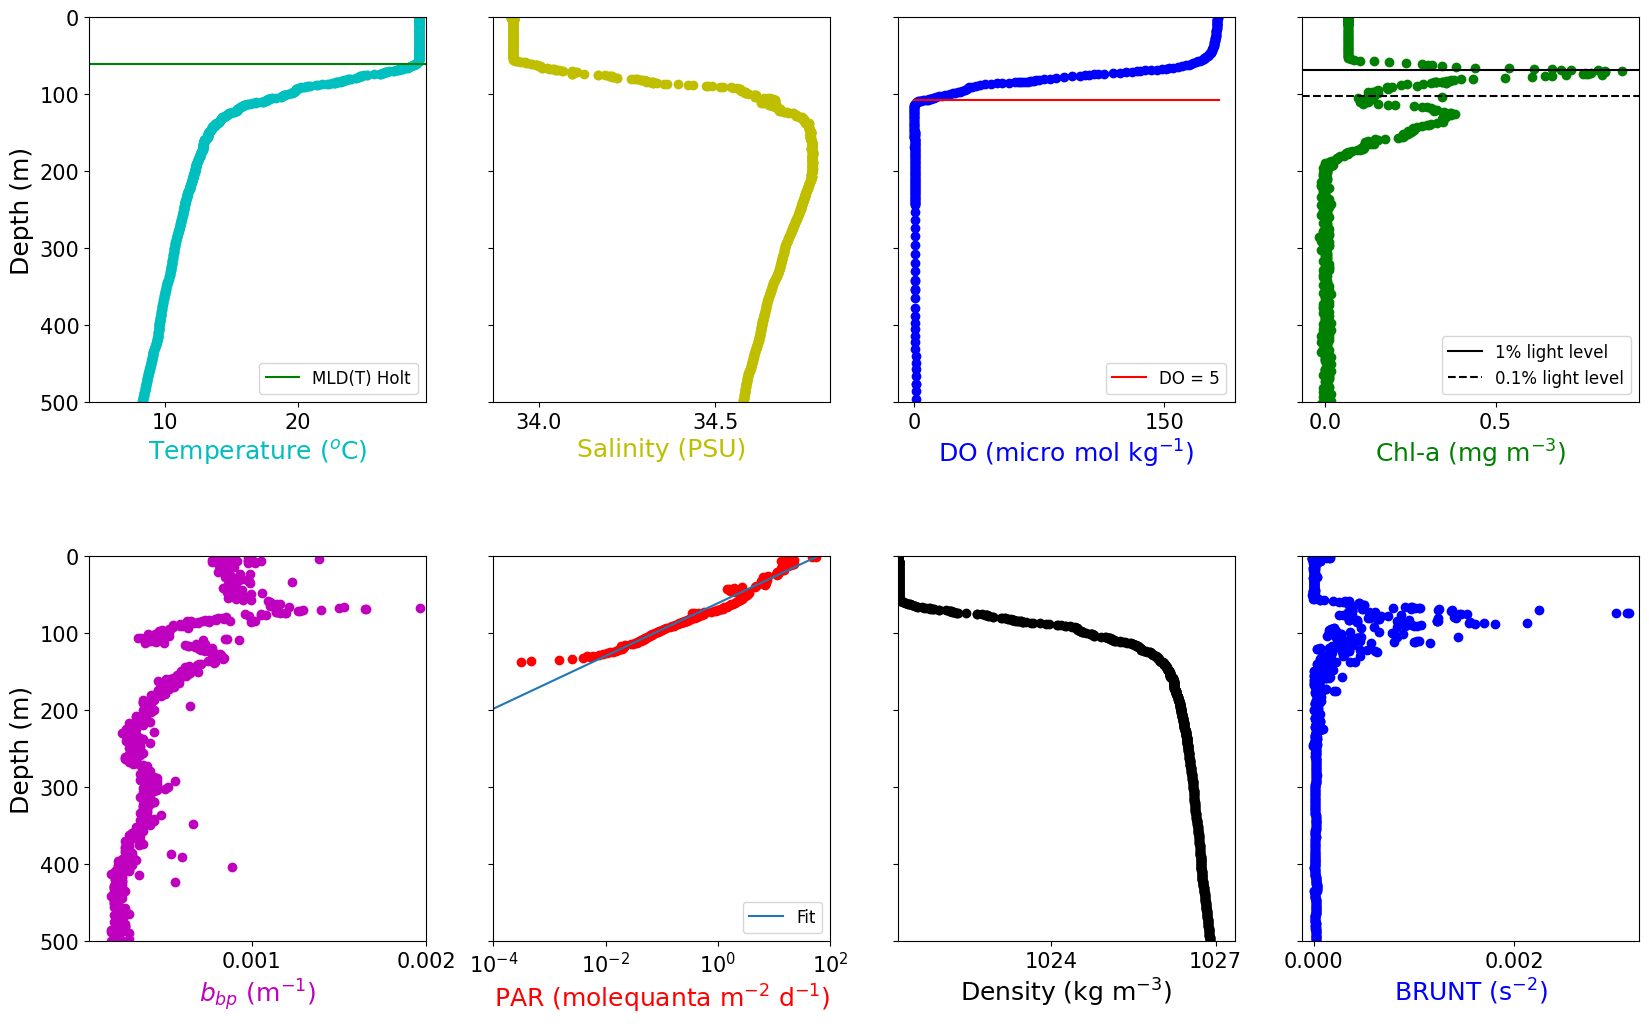

2017-06-04T18:43:00


In [7]:
#Figure parameters that can be changed 
INDEX_PROFILE   = 38    #Cycle number, it can be changed to look at different profiles
XSIZE           = 20    #Define the xsize of the figure window
YSIZE           = 12     #Define the ysize of the figure window
Title_font_size = 18    #Define the font size of the titles
Label_font_size = 15    #Define the font size of the labels
TEMP_MARKER     = 'o'   #Temperature markers see https://matplotlib.org/3.3.1/api/markers_api.html
TEMP_COLOUR     = 'c'   #Temperature colours see https://matplotlib.org/2.0.2/api/colors_api.html
PSAL_MARKER     = 'o'   #Salinity markers see https://matplotlib.org/3.3.1/api/markers_api.html
PSAL_COLOUR     = 'y'   #Salinity colours see https://matplotlib.org/2.0.2/api/colors_api.html
DOXY_MARKER     = 'o'   #Dissolved Oxy markers see https://matplotlib.org/3.3.1/api/markers_api.html
DOXY_COLOUR     = 'b'   #Dissolved Oxy colours see https://matplotlib.org/2.0.2/api/colors_api.html
CHLA_MARKER     = 'o'   #Chla markers see https://matplotlib.org/3.3.1/api/markers_api.html
CHLA_COLOUR     = 'g'   #Chla colours see https://matplotlib.org/2.0.2/api/colors_api.html
BBP_MARKER      = 'o'   #backscattering markers see https://matplotlib.org/3.3.1/api/markers_api.html
BBP_COLOUR      = 'm'   #backscattering colours see https://matplotlib.org/2.0.2/api/colors_api.html
PAR_MARKER      = 'o'   #PAR markers see https://matplotlib.org/3.3.1/api/markers_api.html
PAR_COLOUR      = 'r'   #PAR colours 
DENSITY_MARKER  = 'o'   #Density markers see https://matplotlib.org/3.3.1/api/markers_api.html
DENSITY_COLOUR  = 'k'   #Density colours
BRUNT_MARKER    = 'o'   #BRUNT markers see https://matplotlib.org/3.3.1/api/markers_api.html
BRUNT_COLOUR    = 'b'   #BRUNT colours

#Check INDEX_PROFILE is greater than maximum cycle number
if INDEX_PROFILE > np.max(CYCLE_NUMBER):
    print("ERROR INDEX_PROFILE number is higher than maximum cycle number")

#Check INDEX_PROFILE is less than minimum cycle number
if INDEX_PROFILE < np.min(CYCLE_NUMBER):
    print("ERROR INDEX_PROFILE number is lower than minimum cycle number")

#If between max and min then begin plot
if INDEX_PROFILE >= np.min(CYCLE_NUMBER) and INDEX_PROFILE <= np.max(CYCLE_NUMBER):
    
    #Python indexes starts at 0, whereas cycle starts at 1, so we minus 1 so make index same as cycle
    INDEX_PROFILE = INDEX_PROFILE - 1 
    
    FINAL_model = np.exp(G1[INDEX_PROFILE])*np.exp(-Kd_fit[INDEX_PROFILE]*PRESSURE[INDEX_PROFILE,:])
    
    #Define the figure window including 5 subplots orientated horizontally
    fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2,4, sharey=True, figsize=(XSIZE,YSIZE), \
    gridspec_kw={'hspace': 0.4})
    fig.patch.set_facecolor('White')

    #Temperature subplot
    ax1.plot(TEMP[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
         color = TEMP_COLOUR, marker = TEMP_MARKER, linestyle = 'None')
    ax1.set_ylabel('Depth (m)', fontsize=Title_font_size)
    ax1.yaxis.set_tick_params(labelsize=Label_font_size)
    ax1.set_ylim([500,0]) 
    ax1.set_xlabel('Temperature ($^o$C)', fontsize=Title_font_size, color = TEMP_COLOUR)
    ax1.xaxis.set_tick_params(labelsize=Label_font_size)
    ax1.set_xlim(xmin=np.nanmin(TEMP[INDEX_PROFILE,:])-0.5, xmax=np.nanmax(TEMP[INDEX_PROFILE,:])+0.5)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax1.plot([np.nanmin(TEMP[INDEX_PROFILE,:])-0.5,np.nanmax(TEMP[INDEX_PROFILE,:])+0.5],[MLD_TEMP_ARRAY[INDEX_PROFILE],MLD_TEMP_ARRAY[INDEX_PROFILE]],linestyle = '-', color = 'g', label = 'MLD(T) Holt')
    ax1.legend(loc="lower right", fontsize=12)
    
    #Salinity subplot
    ax2.plot(PSAL[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
         color = PSAL_COLOUR, marker = PSAL_MARKER, linestyle = 'None') 
    ax2.set_xlabel('Salinity (PSU)', fontsize=Title_font_size, color = PSAL_COLOUR)
    ax2.xaxis.set_tick_params(labelsize=Label_font_size)
    ax2.set_xlim(xmin=np.nanmin(PSAL[INDEX_PROFILE,:])-0.05,xmax=np.nanmax(PSAL[INDEX_PROFILE,:])+0.05)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
    
    #Dissolved Oxygen subplot
    ax3.plot(DISS_OXY[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
         color = DOXY_COLOUR, marker = DOXY_MARKER, linestyle = 'None') 
    ax3.set_xlabel('DO (micro mol kg$^{-1}$)', fontsize=Title_font_size, color= DOXY_COLOUR)
    ax3.plot([np.nanmin(DISS_OXY[INDEX_PROFILE,:])-0.5,np.nanmax(DISS_OXY[INDEX_PROFILE,:])+0.5],[DOXY_1_DEPTH[INDEX_PROFILE],DOXY_1_DEPTH[INDEX_PROFILE]],linestyle = '-', color = 'r', label = 'DO = 5')
    ax3.xaxis.set_tick_params(labelsize=Label_font_size)
    ax3.set_xlim(xmin=np.nanmin(DISS_OXY[INDEX_PROFILE,:])-10,xmax=np.nanmax(DISS_OXY[INDEX_PROFILE,:])+10)
    ax3.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax3.legend(loc="lower right", fontsize=12)
    
    #Chl-a subplot
    ax4.plot(CHLA[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
               color = CHLA_COLOUR, marker = CHLA_MARKER, linestyle = 'None')  
    ax4.set_xlabel('Chl-a (mg m$^{-3}$)', fontsize=Title_font_size, color = CHLA_COLOUR)
    ax4.xaxis.set_tick_params(labelsize=Label_font_size)
    ax4.set_xlim(xmin=np.nanmin(CHLA[INDEX_PROFILE,:])-0.05,xmax=np.nanmax(CHLA[INDEX_PROFILE,:])+0.05)
    ax4.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax4.plot([np.nanmin(CHLA[INDEX_PROFILE,:])-0.05,np.nanmax(CHLA[INDEX_PROFILE,:])+0.05],[Zp[INDEX_PROFILE],Zp[INDEX_PROFILE]],linestyle = '-', color = 'k', label = '1% light level')
    ax4.plot([np.nanmin(CHLA[INDEX_PROFILE,:])-0.05,np.nanmax(CHLA[INDEX_PROFILE,:])+0.05],[Zp[INDEX_PROFILE]*1.5,Zp[INDEX_PROFILE]*1.5],linestyle = '--', color = 'k', label = '0.1% light level')
    ax4.legend(loc="lower right", fontsize=12)
    
    #Backscattering subplot
    ax5.plot(BBP[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
               color = BBP_COLOUR, marker = BBP_MARKER, linestyle = 'None')  
    ax5.set_xlabel('$b_{bp}$ (m$^{-1}$)', fontsize=Title_font_size, color = BBP_COLOUR)
    ax5.xaxis.set_tick_params(labelsize=Label_font_size)
    ax5.set_xlim(xmin=np.nanmin(BBP[INDEX_PROFILE,:])-0.0001,xmax=0.002)
    ax5.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax5.yaxis.set_tick_params(labelsize=Label_font_size)
    ax5.set_ylabel('Depth (m)', fontsize=Title_font_size)
        
     #PAR subplot
    ax6.plot(PAR[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
               color = PAR_COLOUR, marker = PAR_MARKER, linestyle = 'None')  
    ax6.plot(FINAL_model,PRESSURE[INDEX_PROFILE,:], linestyle = '-', label = 'Fit' )
    ax6.set_xlabel('PAR (molequanta m$^{-2}$ d$^{-1}$)', fontsize=Title_font_size, color = PAR_COLOUR)
    ax6.xaxis.set_tick_params(labelsize=Label_font_size)
    ax6.set_xlim(xmin=np.nanmin(PAR[INDEX_PROFILE,:])-0.0001,xmax=np.nanmax(PAR[INDEX_PROFILE,:])+0.0001)
    ax6.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax6.legend(loc="lower right", fontsize=12)
    ax6.set_xscale('log')
    ax6.set_xlim([0.0001,100])
    
    #Density subplot
    ax7.plot(DENSITY[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
               color = DENSITY_COLOUR, marker = DENSITY_MARKER, linestyle = 'None')  
    ax7.set_xlabel('Density (kg m$^{-3}$)', fontsize=Title_font_size, color = DENSITY_COLOUR)
    ax7.xaxis.set_tick_params(labelsize=Label_font_size)
    ax7.set_xlim(xmin=np.nanmin(DENSITY[INDEX_PROFILE,:])-0.0001,xmax=np.nanmax(DENSITY[INDEX_PROFILE,:])+0.0001)
    ax7.xaxis.set_major_locator(plt.MaxNLocator(2))
    
    #BRUNT subplot
    ax8.plot(BRUNT[INDEX_PROFILE,:],PRESSURE[INDEX_PROFILE,:], \
               color = BRUNT_COLOUR, marker = BRUNT_MARKER, linestyle = 'None')  
    ax8.set_xlabel('BRUNT (s$^{-2}$)', fontsize=Title_font_size, color = BRUNT_COLOUR)
    ax8.xaxis.set_tick_params(labelsize=Label_font_size)
    ax8.set_xlim(xmin=np.nanmin(BRUNT[INDEX_PROFILE,:])-0.0001,xmax=np.nanmax(BRUNT[INDEX_PROFILE,:])+0.0001)
    ax8.xaxis.set_major_locator(plt.MaxNLocator(2))

    #Complete the plot
    plt.show()
    
    print(TIME_BGC[INDEX_PROFILE])

# Example fit for Chl-a and particle backscattering (Figure 2 of the paper, same profile as above)

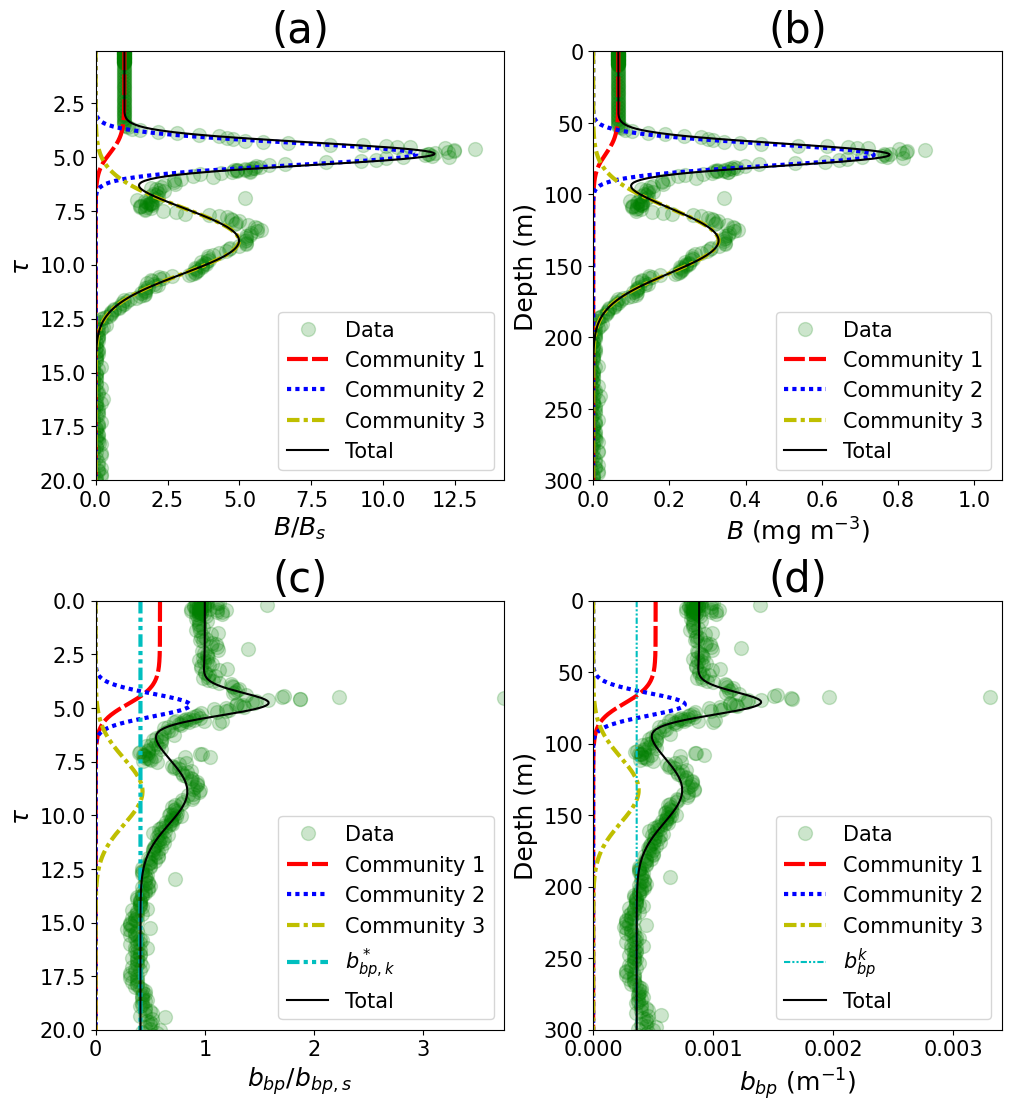

In [8]:
# Process data to be used for fit
Y        = DEPTH[INDEX_PROFILE,:]*Kd_fit[INDEX_PROFILE]
X        = CHLA[INDEX_PROFILE,:]/Surf_CHL[INDEX_PROFILE]
MLD_OD   = MLD_TEMP_ARRAY[INDEX_PROFILE]*Kd_fit[INDEX_PROFILE]
O        = DISS_OXY[INDEX_PROFILE,:]
CHL_DIM  = X
OPT_DIM  = Y
Z        = CHLA[INDEX_PROFILE,:]
Q        = DEPTH[INDEX_PROFILE,:]
valid1   = np.where(Y >= 0)
X        = X[valid1]
Y        = Y[valid1]
Z        = Z[valid1]
O        = O[valid1]
Q        = Q[valid1]
valid1   = np.where(X >= 0)
X        = X[valid1]
Y        = Y[valid1]
Z        = Z[valid1]
O        = O[valid1]
Q        = Q[valid1]

#Only dasta in top 300 m 
asd = np.where(Q <= 300)
X        = X[asd]
Y        = Y[asd]
Z        = Z[asd]
O        = O[asd]
Q        = Q[asd]

if len(X) > 10:
    # Compute parameters of 1st population
    params2  = Parameters()
    Tau1_temp = (MLD_OD*0.62)+2.296
    P1_temp   = 10**(0.08 * Tau1_temp + 0.66)
    params2.add('P1', value=P1_temp, vary=False)#, min = 4.6, max = 8.)
    params2.add('P2', value=Tau1_temp, vary=False)#, min=1.0, max = 3.0)
        
    ### Max of DCM 1
    ads = np.where(O > 5.0)
    Y1 = Y[ads]
    X1 = X[ads]
    DCM1_MAX   = np.max(X1)
    ads = np.where(X1 == np.max(X1))
    DCM1_DEPTH = Y1[ads]  ###divide by three to account for nature of equation
        
    ### Max of DCM 2
    ads = np.where(O < 5.0)
    Y1 = Y[ads]
    X1 = X[ads]
    DCM2_MAX   = np.max(X1)
    ads = np.where(X1 == np.max(X1))
    DCM2_DEPTH = Y1[ads]  

    params2.add('P3', value=DCM1_MAX, min = 0.0, max = 100.0)
    params2.add('P4', value=DCM1_DEPTH[0], min = 0.0, max = DCM2_DEPTH[0])
    params2.add('P5', value=1.0, min = 0.0)
    params2.add('P6', value=DCM2_MAX, min=0.0, max=100)
    params2.add('P7', value=DCM2_DEPTH[0], min = DCM1_DEPTH[0], max = 20.)
    params2.add('P8', value=1.0, min = 0)
    res     = Minimizer(fcn2min_2pop,  params2, fcn_args=(X, Y))
    result  = res.minimize()
    P1_FIT = result.params['P1'].value
    P2_FIT = result.params['P2'].value
    P3_FIT = result.params['P3'].value
    P4_FIT = result.params['P4'].value
    P5_FIT = result.params['P5'].value
    P6_FIT = result.params['P6'].value
    P7_FIT = result.params['P7'].value
    P8_FIT = result.params['P8'].value
else:
    P1_FIT = nan
    P2_FIT = nan
    P3_FIT = nan
    P4_FIT = nan
    P5_FIT = nan
    P6_FIT = nan
    P7_FIT = nan
    P8_FIT = nan

#Compute Chl-a model data
Y            = DEPTH[INDEX_PROFILE,:]*Kd_fit[INDEX_PROFILE] #Kd is G2_fit
X            = CHLA[INDEX_PROFILE,:]/Surf_CHL[INDEX_PROFILE]
MODEL        = (1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y-P2_FIT)))) + P3_FIT*np.exp(-((Y-P4_FIT)/P5_FIT)**2) + P6_FIT*np.exp(-((Y-P7_FIT)/P8_FIT)**2)
COM1         = (1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y-P2_FIT))))
COM2         = P3_FIT*np.exp(-((Y-P4_FIT)/P5_FIT)**2) 
COM3         = P6_FIT*np.exp(-((Y-P7_FIT)/P8_FIT)**2)

#Plot optical depth
XSIZE = 10 #Define the xsize of the figure window
YSIZE = 11 #Define the ysize of the figure window

#Set plot up
fig, ([ax1, ax2],[ax3, ax4],) = plt.subplots(2,2, figsize=(XSIZE,YSIZE), constrained_layout=True)
fig.patch.set_facecolor('White')
ax1.plot(X,Y,color = CHLA_COLOUR, marker = CHLA_MARKER, linestyle = 'None', label = 'Data',alpha=.2, ms = 10)  


# Plot Chl-a results
ax1.plot(COM1,Y,color = 'r', label = 'Community 1',linewidth=3.0, linestyle=(0, (5, 1)))
ax1.plot(COM2,Y,color = 'b', label = 'Community 2',linewidth=3.0, linestyle=(0, (1, 1)))
ax1.plot(COM3,Y,color = 'y', label = 'Community 3',linewidth=3.0, linestyle=(0, (3, 1, 1, 1)))
ax1.plot(MODEL,Y,color = 'k', label = 'Total',linewidth=1.5)
ax1.set_ylim([20,0.1])
ax1.set_xlim([0,np.nanmax(X)+1])
ax1.set_ylabel('$\\tau$', fontsize = Title_font_size)
ax1.set_xlabel('$\it{B}$/$\it{B_s}$', fontsize = Title_font_size)
ax1.legend(loc="lower right", fontsize=15) 
ax1.tick_params(axis='x', labelsize= 15)
ax1.tick_params(axis='y', labelsize= 15)
ax1.set_title('(a)', fontsize=30, color='k')

ax2.plot(CHLA[INDEX_PROFILE,:],DEPTH[INDEX_PROFILE,:],color = CHLA_COLOUR, marker = CHLA_MARKER, linestyle = 'None',label = 'Data',alpha=.2, ms = 10)  
ax2.plot(COM1*Surf_CHL[INDEX_PROFILE],Y/Kd_fit[INDEX_PROFILE],color = 'r', label = 'Community 1',linewidth=3.0, linestyle=(0, (5, 1)))
ax2.plot(COM2*Surf_CHL[INDEX_PROFILE],Y/Kd_fit[INDEX_PROFILE],color = 'b', label = 'Community 2',linewidth=3.0, linestyle=(0, (1, 1)))
ax2.plot(COM3*Surf_CHL[INDEX_PROFILE],Y/Kd_fit[INDEX_PROFILE],color = 'y', label = 'Community 3',linewidth=3.0, linestyle=(0, (3, 1, 1, 1)))
ax2.plot(MODEL*Surf_CHL[INDEX_PROFILE],Y/Kd_fit[INDEX_PROFILE],color = 'k',label = 'Total',linewidth=1.5, linestyle='solid')
ax2.set_ylim([300,0.])
ax2.set_xlim([0,np.nanmax(CHLA[INDEX_PROFILE,:])+0.2])
ax2.set_ylabel('Depth (m)', fontsize = Title_font_size)
ax2.set_xlabel('$\it{B}$ (mg m$^{-3}$)', fontsize = Title_font_size)
ax2.legend(loc="lower right", fontsize=15) 
ax2.tick_params(axis='x', labelsize= 15)
ax2.tick_params(axis='y', labelsize= 15)
ax2.set_title('(b)', fontsize=30, color='k')

# Process data to be used for backscattering fit
X1       = BBP[INDEX_PROFILE,:]/Surf_BBP[INDEX_PROFILE]
Y1       = DEPTH[INDEX_PROFILE,:]*Kd_fit[INDEX_PROFILE]
A1       = (1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT))))
A2       = P3_FIT*np.exp(-((Y1-P4_FIT)/P5_FIT)**2) 
A3       = P6_FIT*np.exp(-((Y1-P7_FIT)/P8_FIT)**2)
valid1   = np.where(DEPTH[INDEX_PROFILE,:] <300)
X1       = X1[valid1]
Y1       = Y1[valid1]
A1       = A1[valid1]
A2       = A2[valid1]
A3       = A3[valid1]
valid1   = np.where(Y1 >= 0)
X1       = X1[valid1]
Y1       = Y1[valid1]
A1       = A1[valid1]
A2       = A2[valid1]
A3       = A3[valid1]
valid1   = np.where(X1 >= 0)
X1       = X1[valid1]
Y1       = Y1[valid1]
A1       = A1[valid1]
A2       = A2[valid1]
A3       = A3[valid1]

if len(X1) > 10:
    #Initial Guess
    params1  = Parameters()
    params1.add('P1', value=0.3, min = 0.05, max = 0.95)
    params1.add('P2', value=0.3, min = 0.05, max = 0.95)
    params1.add('P3', value=0.8, min = 0.05, max = 0.95)
    out     = Minimizer(fcn3min_bbp_norm, params1, fcn_args=(X1, A1, A2, A3))
    result  = out.minimize()
    P1 = 1.0 - result.params['P3'].value
    P2 = result.params['P1'].value
    P3 = result.params['P2'].value
    P4 = result.params['P3'].value
    #report_fit(result)
else:
    P1 = nan
    P2 = nan
    P3 = nan
    P4 = nan

#Compute bbp model data
X1               = BBP[INDEX_PROFILE,:]/Surf_BBP[INDEX_PROFILE]
Y1               = DEPTH[INDEX_PROFILE,:]*Kd_fit[INDEX_PROFILE]
COM1_BBP         = (1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT))))*P1
COM2_BBP         = P3_FIT*np.exp(-((Y1-P4_FIT)/P5_FIT)**2)*P2
COM3_BBP         = P6_FIT*np.exp(-((Y1-P7_FIT)/P8_FIT)**2)*P3
BBP_K            = (COM3_BBP*0)+P4
MODEL_BBP        = COM1_BBP + COM2_BBP + COM3_BBP + BBP_K

# Plot bbp results
ax3.plot(X1,Y1,color = CHLA_COLOUR, marker = CHLA_MARKER,linestyle = 'None', label = 'Data',alpha=.2, ms = 10)  
ax3.plot(COM1_BBP,Y1,color = 'r', label = 'Community 1',linewidth=3.0, linestyle=(0, (5, 1)))
ax3.plot(COM2_BBP,Y1,color = 'b', label = 'Community 2',linewidth=3.0, linestyle=(0, (1, 1)))
ax3.plot(COM3_BBP,Y1,color = 'y', label = 'Community 3',linewidth=3.0, linestyle=(0, (3, 1, 1, 1)))
ax3.plot(BBP_K,Y1,color = 'c', label = '$b^*_{bp,k}$',linewidth=3.0, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax3.plot(MODEL_BBP,Y1,color = 'k', label = 'Total',linewidth=1.5)
ax3.set_ylim([20,0.])
ax3.set_xlim([0,np.nanmax(X1)+0.001])
ax3.set_ylabel('$\\tau$', fontsize = Title_font_size)
ax3.set_xlabel('$b_{bp}$/$b_{bp,s}$', fontsize = Title_font_size)
ax3.legend(loc="lower right", fontsize=15)
ax3.tick_params(axis='x', labelsize= 15)
ax3.tick_params(axis='y', labelsize= 15)
ax3.set_title('(c)', fontsize=30, color='k')

ax4.plot(BBP[INDEX_PROFILE,:],DEPTH[INDEX_PROFILE,:],color = CHLA_COLOUR, marker = CHLA_MARKER, linestyle = 'None',label = 'Data',alpha=.2, ms = 10)  
ax4.plot(COM1_BBP*Surf_BBP[INDEX_PROFILE],Y1/Kd_fit[INDEX_PROFILE],color = 'r', label = 'Community 1',linewidth=3.0, linestyle=(0, (5, 1)))
ax4.plot(COM2_BBP*Surf_BBP[INDEX_PROFILE],Y1/Kd_fit[INDEX_PROFILE],color = 'b', label = 'Community 2',linewidth=3.0, linestyle=(0, (1, 1)))
ax4.plot(COM3_BBP*Surf_BBP[INDEX_PROFILE],Y1/Kd_fit[INDEX_PROFILE],color = 'y', label = 'Community 3',linewidth=3.0, linestyle=(0, (3, 1, 1, 1)))
ax4.plot(BBP_K*Surf_BBP[INDEX_PROFILE],Y1/Kd_fit[INDEX_PROFILE],color = 'c', label = '$b^k_{bp}$', linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax4.plot(MODEL_BBP*Surf_BBP[INDEX_PROFILE], Y1/Kd_fit[INDEX_PROFILE] ,color = 'k', label = 'Total',linewidth=1.5)
ax4.set_ylim([300,0.])
ax4.set_xlim([0,np.nanmax(BBP[INDEX_PROFILE,:])+0.0001])
ax4.set_ylabel('Depth (m)', fontsize = Title_font_size)
ax4.set_xlabel('$b_{bp}$ (m$^{-1}$)', fontsize = Title_font_size)
ax4.tick_params(axis='x', labelsize= 15)
ax4.tick_params(axis='y', labelsize= 15)
ax4.legend(loc="lower right", fontsize=15)
ax4.set_title('(d)', fontsize=30, color='k')

plt.show()

## Fit model to all profiles (Supplementary Figure of parameter time-series)
- LOOP THROUGH EACH PROFILE AND FIT THE MODEL
- OPTION FOR BOOTSTRAPPING (BOOTIT), SET TO ONE (SWITCHED OFF FOR THIS EXAMPLE)

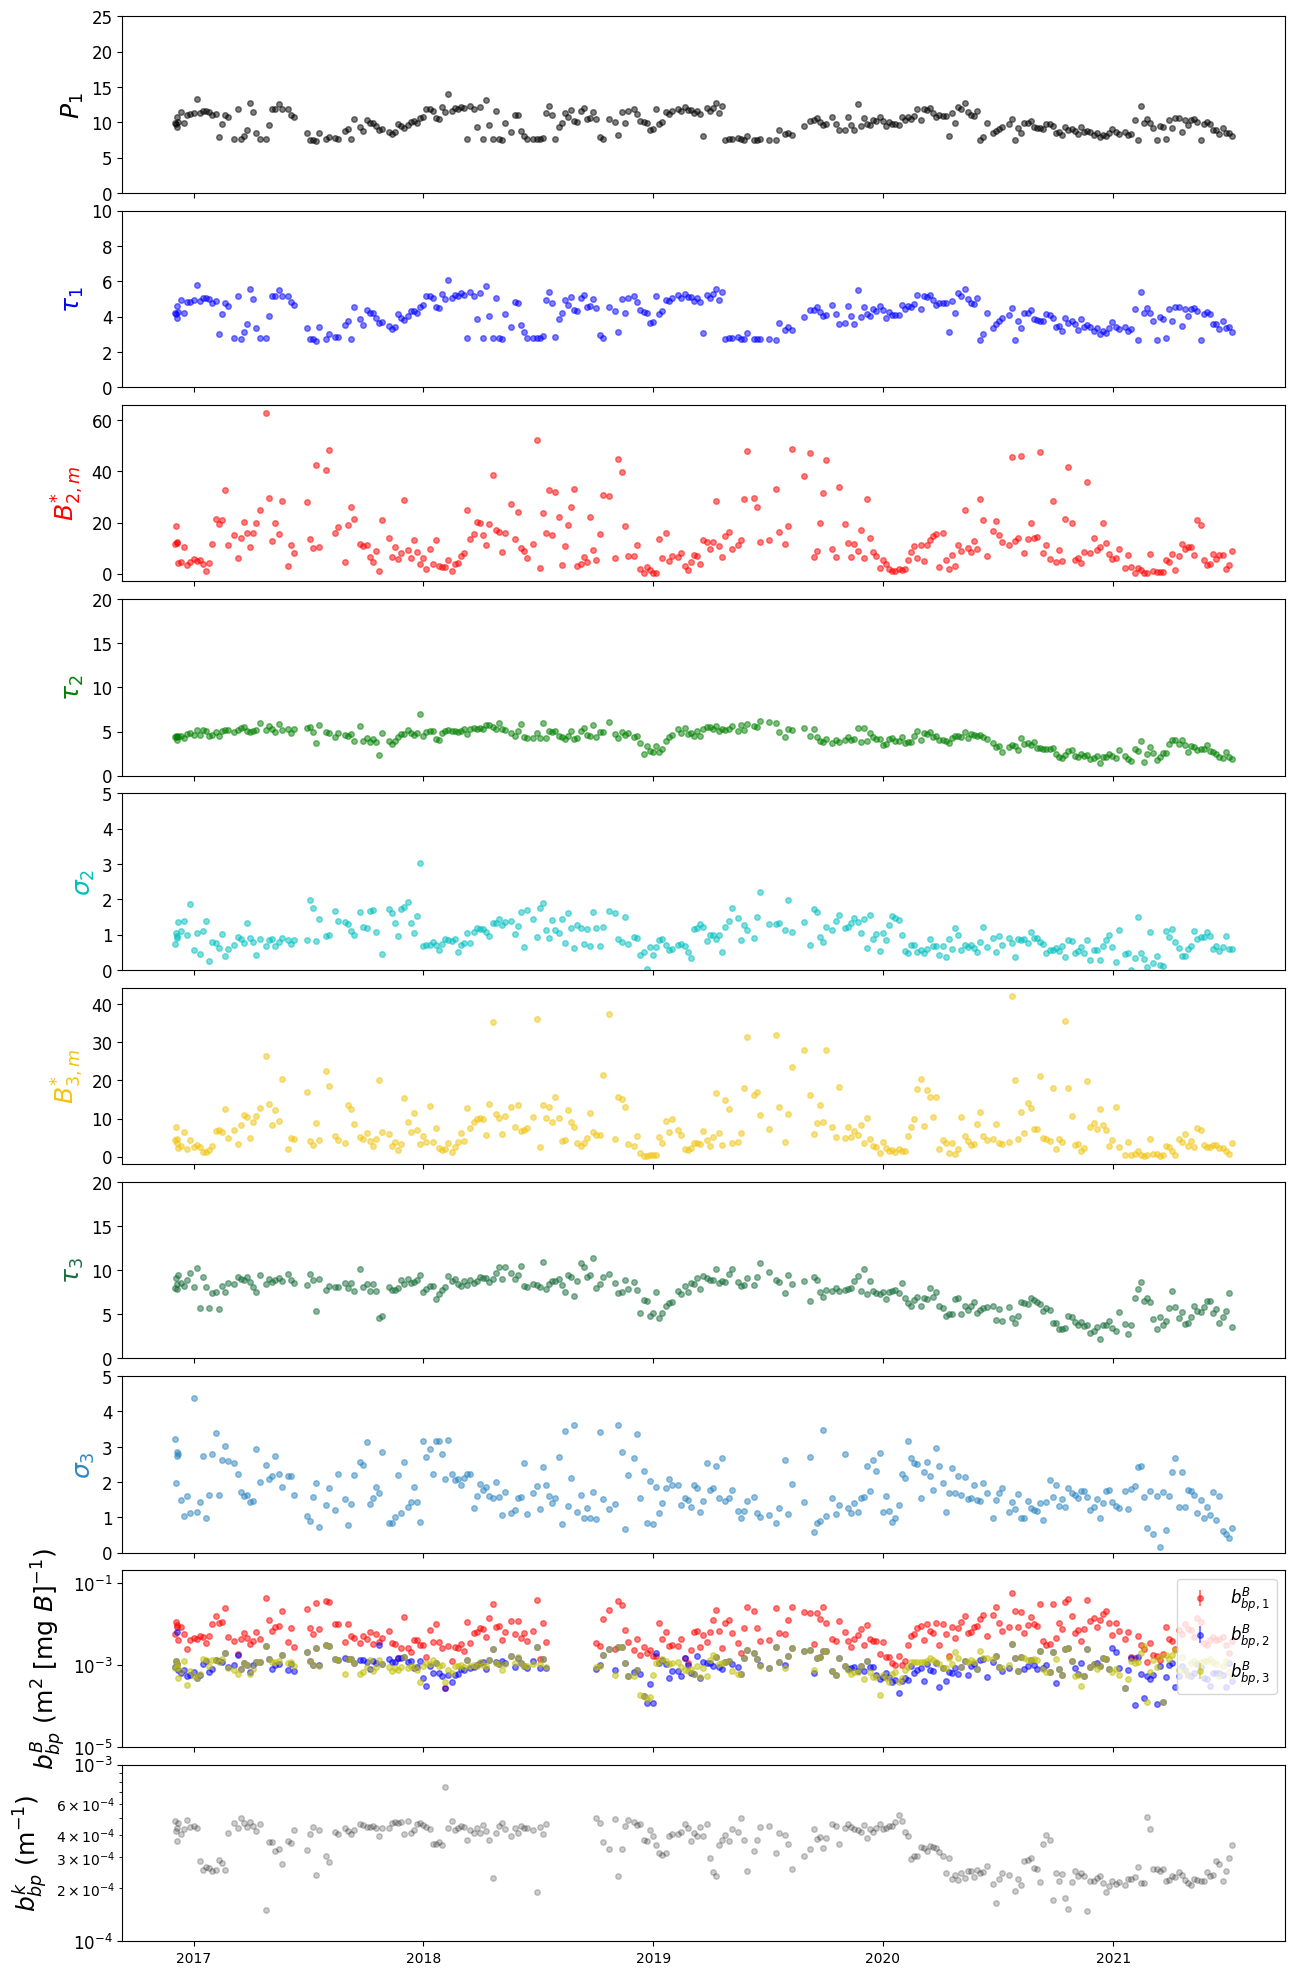

In [9]:
#Number of bootstraps (NB: Bootstrapping not used in this paper, so set to one)
BOOTIT = 1

# Create array of parameters
P1_ARRAY        = np.empty([len(JULD)])+nan
P1_ARRAY_LB     = np.empty([len(JULD)])+nan
P1_ARRAY_UB     = np.empty([len(JULD)])+nan
S1_ARRAY        = np.empty([len(JULD)])+nan
S1_ARRAY_LB     = np.empty([len(JULD)])+nan
S1_ARRAY_UB     = np.empty([len(JULD)])+nan
TAU1_ARRAY      = np.empty([len(JULD)])+nan
TAU1_ARRAY_LB   = np.empty([len(JULD)])+nan
TAU1_ARRAY_UB   = np.empty([len(JULD)])+nan
BM2_ARRAY       = np.empty([len(JULD)])+nan
BM2_ARRAY_LB    = np.empty([len(JULD)])+nan
BM2_ARRAY_UB    = np.empty([len(JULD)])+nan
TAU2_ARRAY      = np.empty([len(JULD)])+nan
TAU2_ARRAY_LB   = np.empty([len(JULD)])+nan
TAU2_ARRAY_UB   = np.empty([len(JULD)])+nan
SIG2_ARRAY      = np.empty([len(JULD)])+nan
SIG2_ARRAY_LB   = np.empty([len(JULD)])+nan
SIG2_ARRAY_UB   = np.empty([len(JULD)])+nan
BM3_ARRAY       = np.empty([len(JULD)])+nan
BM3_ARRAY_LB    = np.empty([len(JULD)])+nan
BM3_ARRAY_UB    = np.empty([len(JULD)])+nan
TAU3_ARRAY      = np.empty([len(JULD)])+nan
TAU3_ARRAY_LB   = np.empty([len(JULD)])+nan
TAU3_ARRAY_UB   = np.empty([len(JULD)])+nan
SIG3_ARRAY      = np.empty([len(JULD)])+nan
SIG3_ARRAY_LB   = np.empty([len(JULD)])+nan
SIG3_ARRAY_UB   = np.empty([len(JULD)])+nan
bbpS1_ARRAY     = np.empty([len(JULD)])+nan
bbpS1_ARRAY_LB  = np.empty([len(JULD)])+nan
bbpS1_ARRAY_UB  = np.empty([len(JULD)])+nan
bbpS2_ARRAY     = np.empty([len(JULD)])+nan
bbpS2_ARRAY_LB  = np.empty([len(JULD)])+nan
bbpS2_ARRAY_UB  = np.empty([len(JULD)])+nan
bbpS3_ARRAY     = np.empty([len(JULD)])+nan
bbpS3_ARRAY_LB  = np.empty([len(JULD)])+nan
bbpS3_ARRAY_UB  = np.empty([len(JULD)])+nan
bbpk_ARRAY      = np.empty([len(JULD)])+nan
bbpk_ARRAY_LB   = np.empty([len(JULD)])+nan
bbpk_ARRAY_UB   = np.empty([len(JULD)])+nan
bbpST1_ARRAY    = np.empty([len(JULD)])+nan
bbpST1_ARRAY_LB = np.empty([len(JULD)])+nan
bbpST1_ARRAY_UB = np.empty([len(JULD)])+nan
bbpST2_ARRAY    = np.empty([len(JULD)])+nan
bbpST2_ARRAY_LB = np.empty([len(JULD)])+nan
bbpST2_ARRAY_UB = np.empty([len(JULD)])+nan
bbpST3_ARRAY    = np.empty([len(JULD)])+nan
bbpST3_ARRAY_LB = np.empty([len(JULD)])+nan
bbpST3_ARRAY_UB = np.empty([len(JULD)])+nan
bbpSk_ARRAY     = np.empty([len(JULD)])+nan
bbpSk_ARRAY_LB  = np.empty([len(JULD)])+nan
bbpSk_ARRAY_UB  = np.empty([len(JULD)])+nan

Corr_chl = np.empty([len(JULD)])+nan
Corr_bbp = np.empty([len(JULD)])+nan

#Loop through each profile
for INDEX_PROFILE in range(len(JULD)):  

    # Data for fitting
    BBP_DIM  = BBP[INDEX_PROFILE,:]/Surf_BBP[INDEX_PROFILE]
    CHL_DIM  = CHLA[INDEX_PROFILE,:]/Surf_CHL[INDEX_PROFILE]
    OPT_DIM  = DEPTH[INDEX_PROFILE,:]*Kd_fit[INDEX_PROFILE]
    OPT_DIM2 = OPT_DIM
    DEP_TEM  = DEPTH[INDEX_PROFILE,:]
    MLD_OD   = MLD_TEMP_ARRAY[INDEX_PROFILE]*Kd_fit[INDEX_PROFILE]
    OXY_T    = DISS_OXY[INDEX_PROFILE,:]
    
    # Top 300m only
    valid1  = np.where(DEP_TEM <= 300)
    CHL_DIM = CHL_DIM[valid1]
    OPT_DIM = OPT_DIM[valid1]
    DEP_TEM = DEP_TEM[valid1]
    OXY_T   = OXY_T[valid1]
    BBP_DIM = BBP_DIM[valid1]
    OPT_DIM2= OPT_DIM2[valid1]
 
    #Create an array of parameters
    P1_TEMP      = np.empty([BOOTIT])+nan
    S1_TEMP      = np.empty([BOOTIT])+nan
    TAU1_TEMP    = np.empty([BOOTIT])+nan
    BM2_TEMP     = np.empty([BOOTIT])+nan
    TAU2_TEMP    = np.empty([BOOTIT])+nan
    SIG2_TEMP    = np.empty([BOOTIT])+nan
    BM3_TEMP     = np.empty([BOOTIT])+nan
    TAU3_TEMP    = np.empty([BOOTIT])+nan
    SIG3_TEMP    = np.empty([BOOTIT])+nan
    bbpST1_TEMP  = np.empty([BOOTIT])+nan
    bbpST2_TEMP  = np.empty([BOOTIT])+nan
    bbpST3_TEMP  = np.empty([BOOTIT])+nan
    bbpSk_TEMP   = np.empty([BOOTIT])+nan
    bbpS1_TEMP   = np.empty([BOOTIT])+nan
    bbpS2_TEMP   = np.empty([BOOTIT])+nan
    bbpS3_TEMP   = np.empty([BOOTIT])+nan
    bbpk_TEMP    = np.empty([BOOTIT])+nan
        
    for j in range(BOOTIT):
        # Extract data
        CHL_DIM_TEMP  = CHL_DIM
        OPT_DIM_TEMP1 = OPT_DIM
        OXY_T_TEMP    = OXY_T
        BBP_DIM_TEMP  = BBP_DIM
        OPT_DIM_TEMP2 = OPT_DIM2

        # Process data to be used for Chl fit
        X1        = CHL_DIM_TEMP
        Y1        = OPT_DIM_TEMP1
        O1        = OXY_T_TEMP
        valid1    = ~np.isnan(X1)
        X1        = X1[valid1]
        Y1        = Y1[valid1]
        O1        = O1[valid1]
        valid1    = ~np.isnan(Y1)
        X1        = X1[valid1]
        Y1        = Y1[valid1]
        O1        = O1[valid1]
 
        if len(X1) > 10:
            ### Parameters of community 1
            params2  = Parameters()
            Tau1_temp = (MLD_OD*0.62)+2.296
            P1_temp   = 10**(0.08 * Tau1_temp + 0.66)
            params2.add('P1', value=P1_temp, vary=False)#, min = 4.6, max = 8.)
            params2.add('P2', value=Tau1_temp, vary=False)#, min=1.0, max = 3.0)
            ### Max of DCM 1
            ads = np.where(O1 > 5.0)
            Y11 = Y1[ads]
            X11 = X1[ads]       
            DCM1_MAX   = np.max(X11)
            ads = np.where(X11 == np.max(X11))
            DCM1_DEPTH = Y11[ads]  ###divide by three to account for nature of equation
            ### Max of DCM 2
            ads = np.where(O1 < 5.0)
            Y11 = Y1[ads]
            X11 = X1[ads]
            DCM2_MAX   = np.max(X11)
            ads = np.where(X11 == np.max(X11))
            DCM2_DEPTH = Y11[ads]  
            params2.add('P3', value=DCM1_MAX, min = 0.0, max = 100.0)
            params2.add('P4', value=DCM1_DEPTH[0], min = 0.0, max = DCM2_DEPTH[0])
            params2.add('P5', value=1.0, min = 0.0)
            params2.add('P6', value=DCM2_MAX, min=0.0, max=100)
            params2.add('P7', value=DCM2_DEPTH[0], min = DCM1_DEPTH[0], max = 12.)
            params2.add('P8', value=1.0, min = 0)
            res     = Minimizer(fcn2min_2pop,  params2, fcn_args=(X1, Y1))
            result  = res.minimize()
            AIC_FIT2 = result.aic
            CHI_FIT2 = result.chisqr
            P1_FIT = result.params['P1'].value
            P2_FIT = result.params['P2'].value
            P3_FIT = result.params['P3'].value
            P4_FIT = result.params['P4'].value
            P5_FIT = result.params['P5'].value
            P6_FIT = result.params['P6'].value
            P7_FIT = result.params['P7'].value
            P8_FIT = result.params['P8'].value 
            
            MODEL_FITR = X1 + result.residual
            Corr_coffchl = stats.pearsonr(X1, MODEL_FITR)
        else:
            P1_FIT = nan
            P2_FIT = nan
            P3_FIT = nan
            P4_FIT = nan
            P5_FIT = nan
            P6_FIT = nan
            P7_FIT = nan
            P8_FIT = nan
            
        # Save parameters                                                                                                                                                                                                 
        P1_TEMP[j]   = P1_FIT                                                                                                         
        S1_TEMP[j]   = P1_FIT/P2_FIT
        TAU1_TEMP[j] = P2_FIT
        BM2_TEMP[j]  = P3_FIT
        TAU2_TEMP[j] = P4_FIT
        SIG2_TEMP[j] = P5_FIT
        BM3_TEMP[j]  = P6_FIT
        TAU3_TEMP[j] = P7_FIT
        SIG3_TEMP[j] = P8_FIT
        
        # Process data to be used for bbp fit
        X1        = BBP_DIM_TEMP
        Y1        = OPT_DIM_TEMP2
        A1        = 1 - 1./(1+np.exp(-(P1_TEMP[j]/TAU1_TEMP[j])*(Y1-TAU1_TEMP[j])))
        A2        = BM2_TEMP[j]*np.exp(-((Y1 - TAU2_TEMP[j])/SIG2_TEMP[j])**2.)
        A3        = BM3_TEMP[j]*np.exp(-((Y1 - TAU3_TEMP[j])/SIG3_TEMP[j])**2.)
        valid1    = ~np.isnan(X1)
        X1        = X1[valid1]
        Y1        = Y1[valid1]
        A1        = A1[valid1]
        A2        = A2[valid1]
        A3        = A3[valid1]
        valid1    = ~np.isnan(Y1)
        X1        = X1[valid1]
        Y1        = Y1[valid1]
        A1        = A1[valid1]
        A2        = A2[valid1]
        A3        = A3[valid1]
        
        if len(X1) > 10:
            params1  = Parameters()
            params1.add('P1', value=0.3, min = 0.05, max = 0.95)
            params1.add('P2', value=0.3, min = 0.05, max = 0.95)
            params1.add('P3', value=0.8, min = 0.05, max = 0.95)
            out     = Minimizer(fcn3min_bbp_norm, params1, fcn_args=(X1, A1, A2, A3))
            result  = out.minimize() # use powell minimisation method  #method = 'powell'
            MODEL_FITR = X1 + result.residual
            Corr_coffbbp = stats.pearsonr(X1, MODEL_FITR)
            bbpST1_TEMP[j]  = 1 - result.params['P3'].value
            bbpST2_TEMP[j]  = result.params['P1'].value
            bbpST3_TEMP[j]  = result.params['P2'].value
            bbpSk_TEMP[j]   = result.params['P3'].value
            bbpS1_TEMP[j]   = bbpST1_TEMP[j]/(Surf_CHL[INDEX_PROFILE]/Surf_BBP[INDEX_PROFILE])
            bbpS2_TEMP[j]   = bbpST2_TEMP[j]/(Surf_CHL[INDEX_PROFILE]/Surf_BBP[INDEX_PROFILE])
            bbpS3_TEMP[j]   = bbpST3_TEMP[j]/(Surf_CHL[INDEX_PROFILE]/Surf_BBP[INDEX_PROFILE])
            bbpk_TEMP[j]    = bbpSk_TEMP[j]*Surf_BBP[INDEX_PROFILE]
        else:
            bbpST1_TEMP[j]  = nan
            bbpST2_TEMP[j]  = nan
            bbpST3_TEMP[j]  = nan
            bbpSk_TEMP[j]   = nan
            bbpS1_TEMP[j]   = nan
            bbpS2_TEMP[j]   = nan
            bbpS3_TEMP[j]   = nan
            bbpk_TEMP[j]    = nan
            

    # Compute median and percentiles of bootstrap
    UB_PERC = 97.5
    LB_PERC = 2.5
    P1_ARRAY[INDEX_PROFILE]        = np.nanmedian(P1_TEMP)
    P1_ARRAY_LB[INDEX_PROFILE]     = np.nanpercentile(P1_TEMP,LB_PERC)
    P1_ARRAY_UB[INDEX_PROFILE]     = np.nanpercentile(P1_TEMP,UB_PERC)
    S1_ARRAY[INDEX_PROFILE]        = np.nanmedian(S1_TEMP)
    S1_ARRAY_LB[INDEX_PROFILE]     = np.nanpercentile(S1_TEMP,LB_PERC)
    S1_ARRAY_UB[INDEX_PROFILE]     = np.nanpercentile(S1_TEMP,UB_PERC)
    TAU1_ARRAY[INDEX_PROFILE]      = np.nanmedian(TAU1_TEMP)
    TAU1_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(TAU1_TEMP,LB_PERC)
    TAU1_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(TAU1_TEMP,UB_PERC)
    BM2_ARRAY[INDEX_PROFILE]       = np.nanmedian(BM2_TEMP)
    BM2_ARRAY_LB[INDEX_PROFILE]    = np.nanpercentile(BM2_TEMP,LB_PERC)
    BM2_ARRAY_UB[INDEX_PROFILE]    = np.nanpercentile(BM2_TEMP,UB_PERC)
    TAU2_ARRAY[INDEX_PROFILE]      = np.nanmedian(TAU2_TEMP)
    TAU2_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(TAU2_TEMP,LB_PERC)
    TAU2_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(TAU2_TEMP,UB_PERC)
    SIG2_ARRAY[INDEX_PROFILE]      = np.nanmedian(SIG2_TEMP)
    SIG2_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(SIG2_TEMP,LB_PERC)
    SIG2_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(SIG2_TEMP,UB_PERC)
    BM3_ARRAY[INDEX_PROFILE]       = np.nanmedian(BM3_TEMP)
    BM3_ARRAY_LB[INDEX_PROFILE]    = np.nanpercentile(BM3_TEMP,LB_PERC)
    BM3_ARRAY_UB[INDEX_PROFILE]    = np.nanpercentile(BM3_TEMP,UB_PERC)
    TAU3_ARRAY[INDEX_PROFILE]      = np.nanmedian(TAU3_TEMP)
    TAU3_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(TAU3_TEMP,LB_PERC)
    TAU3_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(TAU3_TEMP,UB_PERC)
    SIG3_ARRAY[INDEX_PROFILE]      = np.nanmedian(SIG3_TEMP)
    SIG3_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(SIG3_TEMP,LB_PERC)
    SIG3_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(SIG3_TEMP,UB_PERC)
    bbpST1_ARRAY[INDEX_PROFILE]    = np.nanmedian(bbpST1_TEMP)
    bbpST1_ARRAY_LB[INDEX_PROFILE] = np.nanpercentile(bbpST1_TEMP,LB_PERC)
    bbpST1_ARRAY_UB[INDEX_PROFILE] = np.nanpercentile(bbpST1_TEMP,UB_PERC)
    bbpST2_ARRAY[INDEX_PROFILE]    = np.nanmedian(bbpST2_TEMP)
    bbpST2_ARRAY_LB[INDEX_PROFILE] = np.nanpercentile(bbpST2_TEMP,LB_PERC)
    bbpST2_ARRAY_UB[INDEX_PROFILE] = np.nanpercentile(bbpST2_TEMP,UB_PERC)
    bbpST3_ARRAY[INDEX_PROFILE]    = np.nanmedian(bbpST3_TEMP)
    bbpST3_ARRAY_LB[INDEX_PROFILE] = np.nanpercentile(bbpST3_TEMP,LB_PERC)
    bbpST3_ARRAY_UB[INDEX_PROFILE] = np.nanpercentile(bbpST3_TEMP,UB_PERC)
    bbpSk_ARRAY[INDEX_PROFILE]     = np.nanmedian(bbpSk_TEMP)
    bbpSk_ARRAY_LB[INDEX_PROFILE]  = np.nanpercentile(bbpSk_TEMP,LB_PERC)
    bbpSk_ARRAY_UB[INDEX_PROFILE]  = np.nanpercentile(bbpSk_TEMP,UB_PERC)
    bbpS1_ARRAY[INDEX_PROFILE]     = np.nanmedian(bbpS1_TEMP)
    bbpS1_ARRAY_LB[INDEX_PROFILE]  = np.nanpercentile(bbpS1_TEMP,LB_PERC)
    bbpS1_ARRAY_UB[INDEX_PROFILE]  = np.nanpercentile(bbpS1_TEMP,UB_PERC)
    bbpS2_ARRAY[INDEX_PROFILE]     = np.nanmedian(bbpS2_TEMP)
    bbpS2_ARRAY_LB[INDEX_PROFILE]  = np.nanpercentile(bbpS2_TEMP,LB_PERC)
    bbpS2_ARRAY_UB[INDEX_PROFILE]  = np.nanpercentile(bbpS2_TEMP,UB_PERC)
    bbpS3_ARRAY[INDEX_PROFILE]     = np.nanmedian(bbpS3_TEMP)
    bbpS3_ARRAY_LB[INDEX_PROFILE]  = np.nanpercentile(bbpS3_TEMP,LB_PERC)
    bbpS3_ARRAY_UB[INDEX_PROFILE]  = np.nanpercentile(bbpS3_TEMP,UB_PERC)
    bbpk_ARRAY[INDEX_PROFILE]      = np.nanmedian(bbpk_TEMP)
    bbpk_ARRAY_LB[INDEX_PROFILE]   = np.nanpercentile(bbpk_TEMP,LB_PERC)
    bbpk_ARRAY_UB[INDEX_PROFILE]   = np.nanpercentile(bbpk_TEMP,UB_PERC)
    Corr_chl[INDEX_PROFILE]        = Corr_coffchl[0]**2
    Corr_bbp[INDEX_PROFILE]        = Corr_coffbbp[0]**2
    
## REMOVE UNUSAL BACKSRRERING PROFILES 
asd = np.where(bbpk_ARRAY >0.001) ##Unusually high
bbpST1_ARRAY[asd]    = nan
bbpST1_ARRAY_LB[asd] = nan
bbpST1_ARRAY_UB[asd] = nan
bbpST2_ARRAY[asd]    = nan
bbpST2_ARRAY_LB[asd] = nan
bbpST2_ARRAY_UB[asd] = nan
bbpST3_ARRAY[asd]    = nan
bbpST3_ARRAY_LB[asd] = nan
bbpST3_ARRAY_UB[asd] = nan    
bbpSk_ARRAY[asd]     = nan
bbpSk_ARRAY_LB[asd]  = nan
bbpSk_ARRAY_UB[asd]  = nan
bbpS1_ARRAY[asd]     = nan
bbpS1_ARRAY_LB[asd]  = nan
bbpS1_ARRAY_UB[asd]  = nan
bbpS2_ARRAY[asd]     = nan
bbpS2_ARRAY_LB[asd]  = nan
bbpS2_ARRAY_UB[asd]  = nan
bbpS3_ARRAY[asd]     = nan
bbpS3_ARRAY_LB[asd]  = nan
bbpS3_ARRAY_UB[asd]  = nan
bbpk_ARRAY[asd]      = nan
bbpk_ARRAY_LB[asd]   = nan
bbpk_ARRAY_UB[asd]   = nan
    
#Plot data
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10,) = plt.subplots(10, sharex=True, figsize=(15,25), \
    gridspec_kw={'hspace': 0.1})
fig.patch.set_facecolor('White')

#P1
ax1.errorbar(TIME_BGC, P1_ARRAY, yerr=(P1_ARRAY-P1_ARRAY_LB, P1_ARRAY_UB-P1_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'k', alpha=.5)
ax1.set_ylabel('$P_1$', fontsize=Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylim(0,25)

#P2
ax2.errorbar(TIME_BGC, TAU1_ARRAY, yerr=(TAU1_ARRAY-TAU1_ARRAY_LB, TAU1_ARRAY_UB-TAU1_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'b', alpha=.5)
ax2.set_ylabel('$\\tau_1$', fontsize=Title_font_size, color='b')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylim(0,10)

#P3
ax3.errorbar(TIME_BGC, BM2_ARRAY, yerr=(BM2_ARRAY-BM2_ARRAY_LB, BM2_ARRAY_UB-BM2_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'r', alpha=.5)
ax3.set_ylabel('$B^{*}_{2,m}$', fontsize=Title_font_size, color='r')
ax3.yaxis.set_tick_params(labelsize=12)

#P4
ax4.errorbar(TIME_BGC, TAU2_ARRAY, yerr=(TAU2_ARRAY-TAU2_ARRAY_LB, TAU2_ARRAY_UB-TAU2_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'g', alpha=.5)
ax4.set_ylabel('${\\tau}_2$', fontsize=Title_font_size, color='g')
ax4.yaxis.set_tick_params(labelsize=12)
ax4.set_ylim(0,20)

#P5
ax5.errorbar(TIME_BGC, SIG2_ARRAY, yerr=(SIG2_ARRAY-SIG2_ARRAY_LB, SIG2_ARRAY_UB-SIG2_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'c', alpha=.5)
ax5.set_ylabel('$\sigma_2$', fontsize=Title_font_size, color='c')
ax5.yaxis.set_tick_params(labelsize=12)
ax5.set_ylim(0,5)

#P6
ax6.errorbar(TIME_BGC, BM3_ARRAY, yerr=(BM3_ARRAY-BM3_ARRAY_LB, BM3_ARRAY_UB-BM3_ARRAY), ms=4, linestyle='None', 
             marker='o', color = '#F1C40F', alpha=.5)
ax6.set_ylabel('$B^{*}_{3,m}$', fontsize=Title_font_size, color='#F1C40F')
ax6.yaxis.set_tick_params(labelsize=12)

#P7
ax7.errorbar(TIME_BGC, TAU3_ARRAY, yerr=(TAU3_ARRAY-TAU3_ARRAY_LB, TAU3_ARRAY_UB-TAU3_ARRAY), ms=4, linestyle='None', 
             marker='o', color = '#196F3D', alpha=.5)
ax7.set_ylabel('${\\tau}_3$', fontsize=Title_font_size, color='#196F3D')
ax7.yaxis.set_tick_params(labelsize=12)
ax7.set_ylim(0,20)

#P8
ax8.errorbar(TIME_BGC, SIG3_ARRAY, yerr=(SIG3_ARRAY-SIG3_ARRAY_LB, SIG3_ARRAY_UB-SIG3_ARRAY), ms=4, linestyle='None', 
             marker='o', color = '#2E86C1', alpha=.5)
ax8.set_ylabel('$\sigma_3$', fontsize=Title_font_size, color='#2E86C1')
ax8.yaxis.set_tick_params(labelsize=12)
ax8.set_ylim(0,5)

#chl-bbp1
ax9.errorbar(TIME_BGC, bbpS1_ARRAY, yerr=(bbpS1_ARRAY-bbpS1_ARRAY_LB, bbpS1_ARRAY_UB-bbpS1_ARRAY), ms=4, linestyle='None', 
             marker='o', color = 'r', label = '$b^B_{bp,1}$', alpha=.5)
ax9.errorbar(TIME_BGC, bbpS2_ARRAY, yerr=(bbpS2_ARRAY-bbpS2_ARRAY_LB, bbpS2_ARRAY_UB-bbpS2_ARRAY),  ms=4, linestyle='None', 
             marker='o', color = 'b', label = '$b^B_{bp,2}$', alpha=.5)
ax9.errorbar(TIME_BGC, bbpS3_ARRAY, yerr=(bbpS3_ARRAY-bbpS3_ARRAY_LB, bbpS3_ARRAY_UB-bbpS3_ARRAY),  ms=4, linestyle='None', 
             marker='o', color = 'y', label = '$b^B_{bp,3}$', alpha=.5)
ax9.set_ylabel('$b^B_{bp}$ (m$^2$ [mg $B$]$^{-1}$)', fontsize=Title_font_size, color='k')
ax9.yaxis.set_tick_params(labelsize=12)
ax9.set_yscale('log')
ax9.legend(loc="upper right", fontsize=12)
ax9.set_ylim(0.00001,0.2)

#chl-bbp1#
ax10.errorbar(TIME_BGC, bbpk_ARRAY, yerr=(bbpk_ARRAY-bbpk_ARRAY_LB, bbpk_ARRAY_UB-bbpk_ARRAY),  ms=4, linestyle='None', 
             marker='o', color = 'k', alpha=.2)
ax10.set_ylabel('$b^k_{bp}$ (m$^{-1}$)', fontsize=Title_font_size, color='k')
ax10.yaxis.set_tick_params(labelsize=12)
ax10.set_ylim(0.0001,0.001)
ax10.set_yscale('log')

plt.show()

## Box plots of key parameters comparing the two DCMs (Community 2 and 3, Figure 4 of paper)

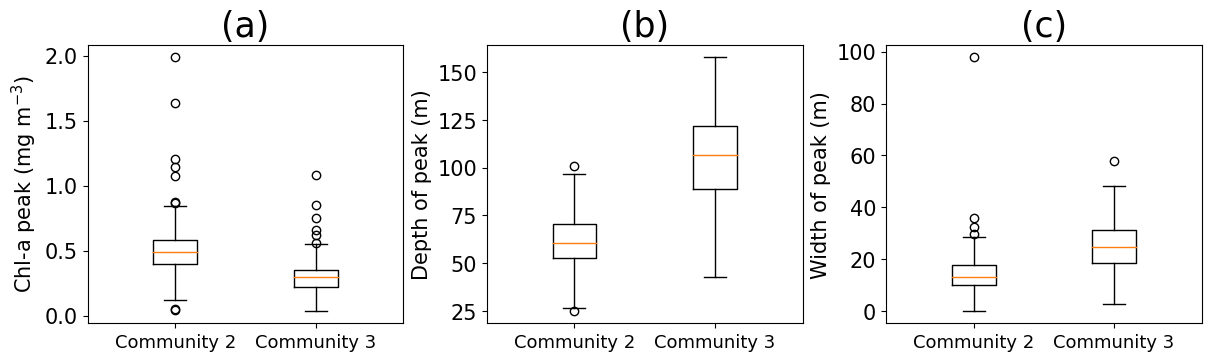

In [10]:
#Set plot up
fig, ([ax2,ax3,ax4]) = plt.subplots(1,3, figsize=(12,3.5), constrained_layout = True)
fig.patch.set_facecolor('White')

#Chl-a peak for 2 DCMS
DATA1 = BM2_ARRAY*Surf_CHL
DATA2 = BM3_ARRAY*Surf_CHL
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax2.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax2.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax2.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax2.set_ylabel('Chl-a peak (mg m$^{-3}$)', fontsize = 15) 
ax2.tick_params(axis='x', labelsize= 13)
ax2.tick_params(axis='y', labelsize= 15)
ax2.set_title('(a)', fontsize=25, color='k')

#Depth of peak for 2 DCMS
DATA1 = TAU2_ARRAY/Kd_fit
DATA2 = TAU3_ARRAY/Kd_fit
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax3.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax3.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax3.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax3.set_ylabel('Depth of peak (m)', fontsize = 15) 
ax3.tick_params(axis='x', labelsize= 13)
ax3.tick_params(axis='y', labelsize= 15)
ax3.set_title('(b)', fontsize=25, color='k')

#Width of peak for 2 DCMS
DATA1 = SIG2_ARRAY/Kd_fit
DATA2 = SIG3_ARRAY/Kd_fit
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax4.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax4.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax4.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax4.set_ylabel('Width of peak (m)', fontsize = 15) 
ax4.tick_params(axis='x', labelsize= 13)
ax4.tick_params(axis='y', labelsize= 15)
ax4.set_title('(c)', fontsize=25, color='k')

plt.show()

## Seasonal box plots of key parameters comparing the two DCMs (Community 2 and 3, Supplementary Figure to the paper)

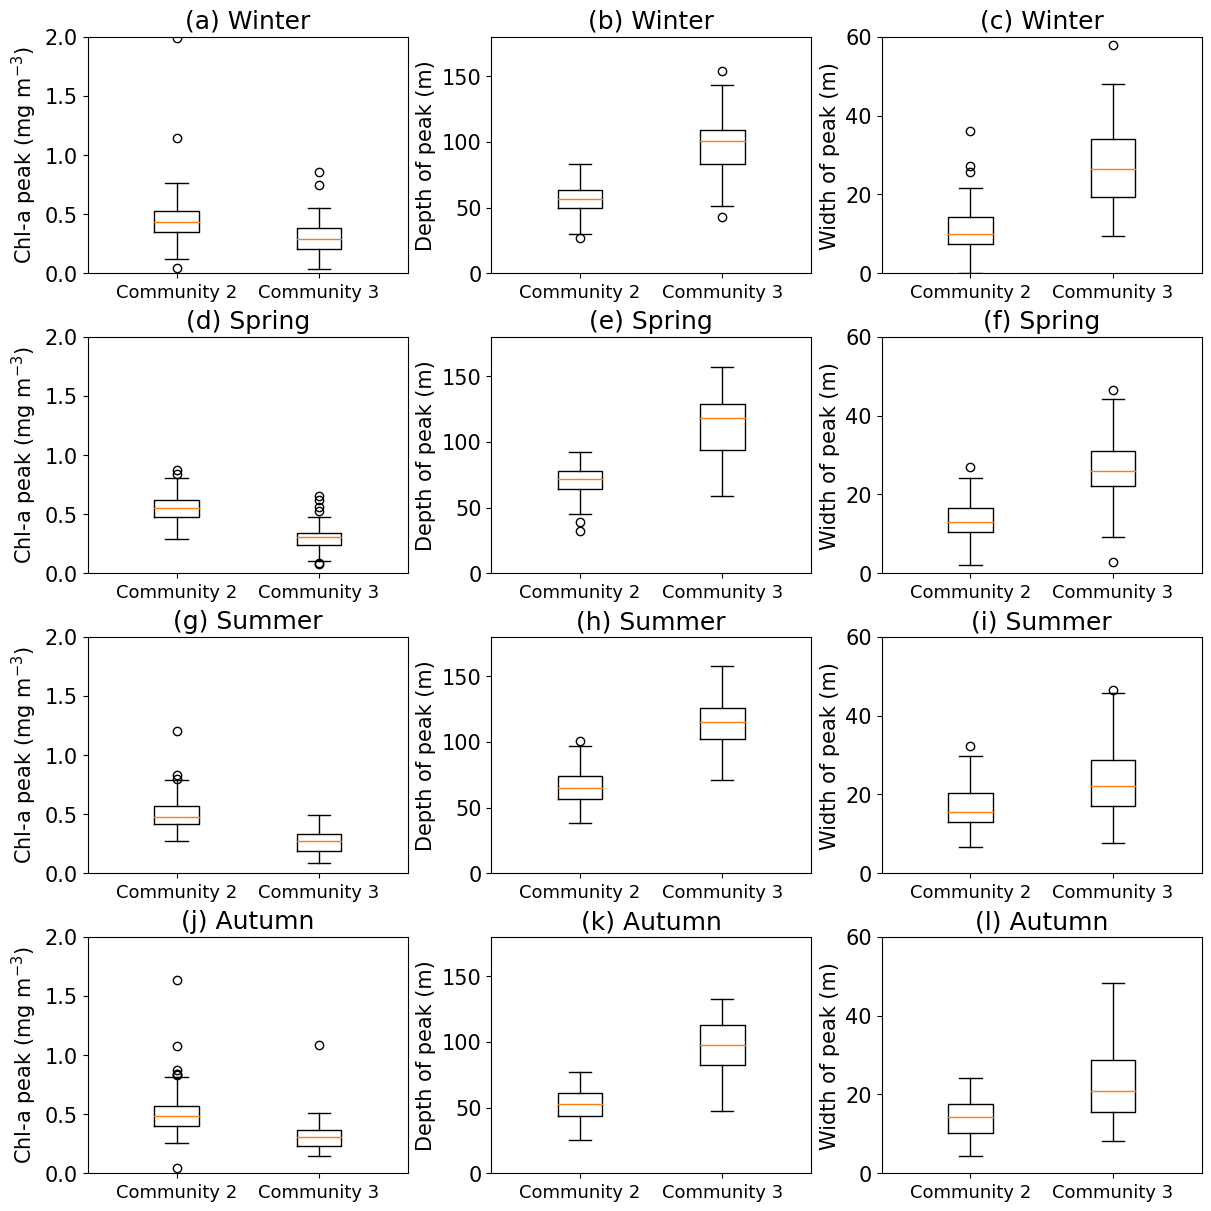

In [11]:
#Extract the month of each profile (used to find all data in a month)
MONTH_BGC          = pd.to_datetime(TIME_BGC).month
SEASON             = np.empty(len(MONTH_BGC))+nan

#Partition months into seasons
for i in range(len(MONTH_BGC)):
    if MONTH_BGC[i] == 12:
        SEASON[i] = 1.
    if MONTH_BGC[i] == 1:
        SEASON[i] = 1.
    if MONTH_BGC[i] == 2:
        SEASON[i] = 1.
    if MONTH_BGC[i] == 3:
        SEASON[i] = 2.        
    if MONTH_BGC[i] == 4:
        SEASON[i] = 2.    
    if MONTH_BGC[i] == 5:
        SEASON[i] = 2. 
    if MONTH_BGC[i] == 6:
        SEASON[i] = 3. 
    if MONTH_BGC[i] == 7:
        SEASON[i] = 3. 
    if MONTH_BGC[i] == 8:
        SEASON[i] = 3. 
    if MONTH_BGC[i] == 9:
        SEASON[i] = 4.   
    if MONTH_BGC[i] == 10:
        SEASON[i] = 4. 
    if MONTH_BGC[i] == 11:
        SEASON[i] = 4. 

#Set plot up
fig, ([ax5,ax6,ax7],[ax8,ax9,ax10],[ax11,ax12,ax13],[ax14,ax15,ax16]) = plt.subplots(4,3, figsize=(12,12), constrained_layout = True)
fig.patch.set_facecolor('White')

####WINTER
ads = np.where(SEASON == 1)

#Chl-a peak for 2 DCMS
DATA1 = BM2_ARRAY[ads]*Surf_CHL[ads]
DATA2 = BM3_ARRAY[ads]*Surf_CHL[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax5.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax5.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax5.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax5.set_ylabel('Chl-a peak (mg m$^{-3}$)', fontsize = 15) 
ax5.tick_params(axis='x', labelsize= 13)
ax5.tick_params(axis='y', labelsize= 15)
ax5.set_title('(a) Winter', fontsize=18, color='k')
ax5.set_ylim([0,2.])

#Depth of peak for 2 DCMS
DATA1 = TAU2_ARRAY[ads]/Kd_fit[ads]
DATA2 = TAU3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax6.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax6.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax6.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax6.set_ylabel('Depth of peak (m)', fontsize = 15) 
ax6.tick_params(axis='x', labelsize= 13)
ax6.tick_params(axis='y', labelsize= 15)
ax6.set_title('(b) Winter', fontsize=18, color='k')
ax6.set_ylim([0,180.])

#Width of peak for 2 DCMS
DATA1 = SIG2_ARRAY[ads]/Kd_fit[ads]
DATA2 = SIG3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax7.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax7.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax7.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax7.set_ylabel('Width of peak (m)', fontsize = 15) 
ax7.tick_params(axis='x', labelsize= 13)
ax7.tick_params(axis='y', labelsize= 15)
ax7.set_title('(c) Winter', fontsize=18, color='k')
ax7.set_ylim([0,60.])

####SPRING
ads = np.where(SEASON == 2)

#Chl-a peak for 2 DCMS
DATA1 = BM2_ARRAY[ads]*Surf_CHL[ads]
DATA2 = BM3_ARRAY[ads]*Surf_CHL[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax8.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax8.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax8.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax8.set_ylabel('Chl-a peak (mg m$^{-3}$)', fontsize = 15) 
ax8.tick_params(axis='x', labelsize= 13)
ax8.tick_params(axis='y', labelsize= 15)
ax8.set_title('(d) Spring', fontsize=18, color='k')
ax8.set_ylim([0,2.])

#Depth of peak for 2 DCMS
DATA1 = TAU2_ARRAY[ads]/Kd_fit[ads]
DATA2 = TAU3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax9.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax9.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax9.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax9.set_ylabel('Depth of peak (m)', fontsize = 15) 
ax9.tick_params(axis='x', labelsize= 13)
ax9.tick_params(axis='y', labelsize= 15)
ax9.set_title('(e) Spring', fontsize=18, color='k')
ax9.set_ylim([0,180.])

#Width of peak for 2 DCMS
DATA1 = SIG2_ARRAY[ads]/Kd_fit[ads]
DATA2 = SIG3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax10.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax10.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax10.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax10.set_ylabel('Width of peak (m)', fontsize = 15) 
ax10.tick_params(axis='x', labelsize= 13)
ax10.tick_params(axis='y', labelsize= 15)
ax10.set_title('(f) Spring', fontsize=18, color='k')
ax10.set_ylim([0,60.])

####SUMMER
ads = np.where(SEASON == 3)

#Chl-a peak for 2 DCMS
DATA1 = BM2_ARRAY[ads]*Surf_CHL[ads]
DATA2 = BM3_ARRAY[ads]*Surf_CHL[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax11.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax11.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax11.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax11.set_ylabel('Chl-a peak (mg m$^{-3}$)', fontsize = 15) 
ax11.tick_params(axis='x', labelsize= 13)
ax11.tick_params(axis='y', labelsize= 15)
ax11.set_title('(g) Summer', fontsize=18, color='k')
ax11.set_ylim([0,2.])

#Depth of peak for 2 DCMS
DATA1 = TAU2_ARRAY[ads]/Kd_fit[ads]
DATA2 = TAU3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax12.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax12.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax12.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax12.set_ylabel('Depth of peak (m)', fontsize = 15) 
ax12.tick_params(axis='x', labelsize= 13)
ax12.tick_params(axis='y', labelsize= 15)
ax12.set_title('(h) Summer', fontsize=18, color='k')
ax12.set_ylim([0,180.])

#Width of peak for 2 DCMS
DATA1 = SIG2_ARRAY[ads]/Kd_fit[ads]
DATA2 = SIG3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax13.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax13.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax13.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax13.set_ylabel('Width of peak (m)', fontsize = 15) 
ax13.tick_params(axis='x', labelsize= 13)
ax13.tick_params(axis='y', labelsize= 15)
ax13.set_title('(i) Summer', fontsize=18, color='k')
ax13.set_ylim([0,60.])

####AUTUN+MN
ads = np.where(SEASON == 4)

#Chl-a peak for 2 DCMS
DATA1 = BM2_ARRAY[ads]*Surf_CHL[ads]
DATA2 = BM3_ARRAY[ads]*Surf_CHL[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax14.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax14.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax14.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax14.set_ylabel('Chl-a peak (mg m$^{-3}$)', fontsize = 15) 
ax14.tick_params(axis='x', labelsize= 13)
ax14.tick_params(axis='y', labelsize= 15)
ax14.set_title('(j) Autumn', fontsize=18, color='k')
ax14.set_ylim([0,2.])

#Depth of peak for 2 DCMS
DATA1 = TAU2_ARRAY[ads]/Kd_fit[ads]
DATA2 = TAU3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax15.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax15.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax15.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax15.set_ylabel('Depth of peak (m)', fontsize = 15) 
ax15.tick_params(axis='x', labelsize= 13)
ax15.tick_params(axis='y', labelsize= 15)
ax15.set_title('(k) Autumn', fontsize=18, color='k')
ax15.set_ylim([0,180.])

#Width of peak for 2 DCMS
DATA1 = SIG2_ARRAY[ads]/Kd_fit[ads]
DATA2 = SIG3_ARRAY[ads]/Kd_fit[ads]
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ax16.boxplot(DATA1, positions = [0.1], widths = 0.25)
ax16.boxplot(DATA2, positions = [0.9], widths = 0.25)
ax16.set_xticklabels(['Community 2','Community 3'], fontsize = 13)
ax16.set_ylabel('Width of peak (m)', fontsize = 15) 
ax16.tick_params(axis='x', labelsize= 13)
ax16.tick_params(axis='y', labelsize= 15)
ax16.set_ylim([0,60.])
ax16.set_title('(l) Autumn', fontsize=18, color='k')

plt.show()


## Re-grid the data to common depth grid for contour plotting

In [12]:
#Create a time matrix needed later for the contour plot (providing time for each depth level)
TIME_BGC_MATRIX_INT = np.empty([len(TEMP[:,0]),2000], dtype='datetime64[s]')
for i in range(2000):
    TIME_BGC_MATRIX_INT[:,i] = TIME_BGC

#Define new interpolated maxrices the same size as the existsing ones
TEMP_INT      = np.empty([len(TEMP[:,0]),2000])#+nan
PSAL_INT      = np.empty([len(TEMP[:,0]),2000])#+nan
DENS_INT      = np.empty([len(TEMP[:,0]),2000])#+nan
BVF_INT       = np.empty([len(TEMP[:,0]),2000])#+nan
CHLA_INT      = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT       = np.empty([len(TEMP[:,0]),2000])#+nan
DISS_OXY_INT  = np.empty([len(TEMP[:,0]),2000])#+nan
CHLA_INT_SIM  = np.empty([len(TEMP[:,0]),2000])#+nan
CHLA_INT_MLCO = np.empty([len(TEMP[:,0]),2000])#+nan
CHLA_INT_DCM1 = np.empty([len(TEMP[:,0]),2000])#+nan
CHLA_INT_DCM2 = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT_SIM   = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT_MLCO  = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT_DCM1  = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT_DCM2  = np.empty([len(TEMP[:,0]),2000])#+nan
BBP_INT_BBK   = np.empty([len(TEMP[:,0]),2000])#+nan
PAR_INT       = np.empty([len(TEMP[:,0]),2000])#+nan
OPTICAL_PRES  = np.empty([len(TEMP[:,0]),2000])#+nan
DEPTH_INT     = np.empty([len(TEMP[:,0]),2000])#+nan

PRESS = np.arange(0, 1000, 0.5)

#Loop through each profile (float cycle)
for i in range(len(JULD)):
    DEPTH_INT[i,:]    = PRESS
    OPTICAL_PRES[i,:] = PRESS * Kd_fit[i]
    
    #Temperature data interpolation
    a      = TEMP[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc         = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx                = interpfunc(PRESS)
    TEMP_INT[i,:] = xxx    
        
    #Salinity data interpolation        
    a      = PSAL[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    PSAL_INT[i,:] = xxx
    
    #Density data interpolation        
    a      = DENSITY[i,:]
    b      = DEPTH[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    DENS_INT[i,:] = xxx
        
    #Dissolved Ocygen data interpolation 
    a      = DISS_OXY[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    DISS_OXY_INT[i,:] = xxx
    
    #BVF Interpolation
    a      = BRUNT[i,:]
    b      = DEPTH[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    BVF_INT[i,:] = xxx
        
    #Chlorophyll-a data interpolation    
    a      = CHLA[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    CHLA_INT[i,:] = xxx

    #Backscattering data interpolation             
    a      = BBP[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    #Median filter the backscattering data for profiles with more than 11 data points
    if len(xxx) > 11:
        BBP_INT[i,:] = scipy.signal.medfilt(xxx, kernel_size=11)
    if len(xxx) < 11:
         BBP_INT[i,:] = xxx
            
    #PAR interpolation 
    a      = PAR[i,:]
    b      = PRESSURE[i,:]
    valid1 = ~np.isnan(b)
    valid2 = ~np.isnan(a)
    a      = a[valid2]
    c      = b[valid2]
    interpfunc    = interpolate.interp1d(c,a, kind='linear',fill_value="extrapolate")
    xxx           = interpfunc(PRESS)
    PAR_INT[i,:] = xxx
            
    #MODEL RESULTS
    Y2                     = PRESS*Kd_fit[i]
    CHLA_INT_SIM[i,:]  = ((1 - 1./(1+np.exp(-(P1_ARRAY[i]/TAU1_ARRAY[i])*(Y2-TAU1_ARRAY[i])))) + BM2_ARRAY[i]*np.exp(-((Y2 - TAU2_ARRAY[i])/SIG2_ARRAY[i])**2.) + BM3_ARRAY[i]*np.exp(-((Y2 - TAU3_ARRAY[i])/SIG3_ARRAY[i])**2.))*Surf_CHL[i]
    CHLA_INT_MLCO[i,:] = (1 - 1./(1+np.exp(-(P1_ARRAY[i]/TAU1_ARRAY[i])*(Y2-TAU1_ARRAY[i]))))*Surf_CHL[i]
    CHLA_INT_DCM1[i,:] = BM2_ARRAY[i]*np.exp(-((Y2 - TAU2_ARRAY[i])/SIG2_ARRAY[i])**2.)*Surf_CHL[i]
    CHLA_INT_DCM2[i,:] = BM3_ARRAY[i]*np.exp(-((Y2 - TAU3_ARRAY[i])/SIG3_ARRAY[i])**2.)*Surf_CHL[i]
    BBP_INT_MLCO[i,:]  = CHLA_INT_MLCO[i,:]*bbpS1_ARRAY[i]
    BBP_INT_DCM1[i,:]  = CHLA_INT_DCM1[i,:]*bbpS2_ARRAY[i]
    BBP_INT_DCM2[i,:]  = CHLA_INT_DCM2[i,:]*bbpS3_ARRAY[i]
    BBP_INT_BBK[i,:]   = (Y2 * 0) + bbpk_ARRAY[i]
    BBP_INT_SIM[i,:]   = BBP_INT_MLCO[i,:]+BBP_INT_DCM1[i,:]+BBP_INT_DCM2[i,:]+BBP_INT_BBK[i,:]                        

## Viewing re-gridded variables from BGC-Argo (Supplementary Figure)

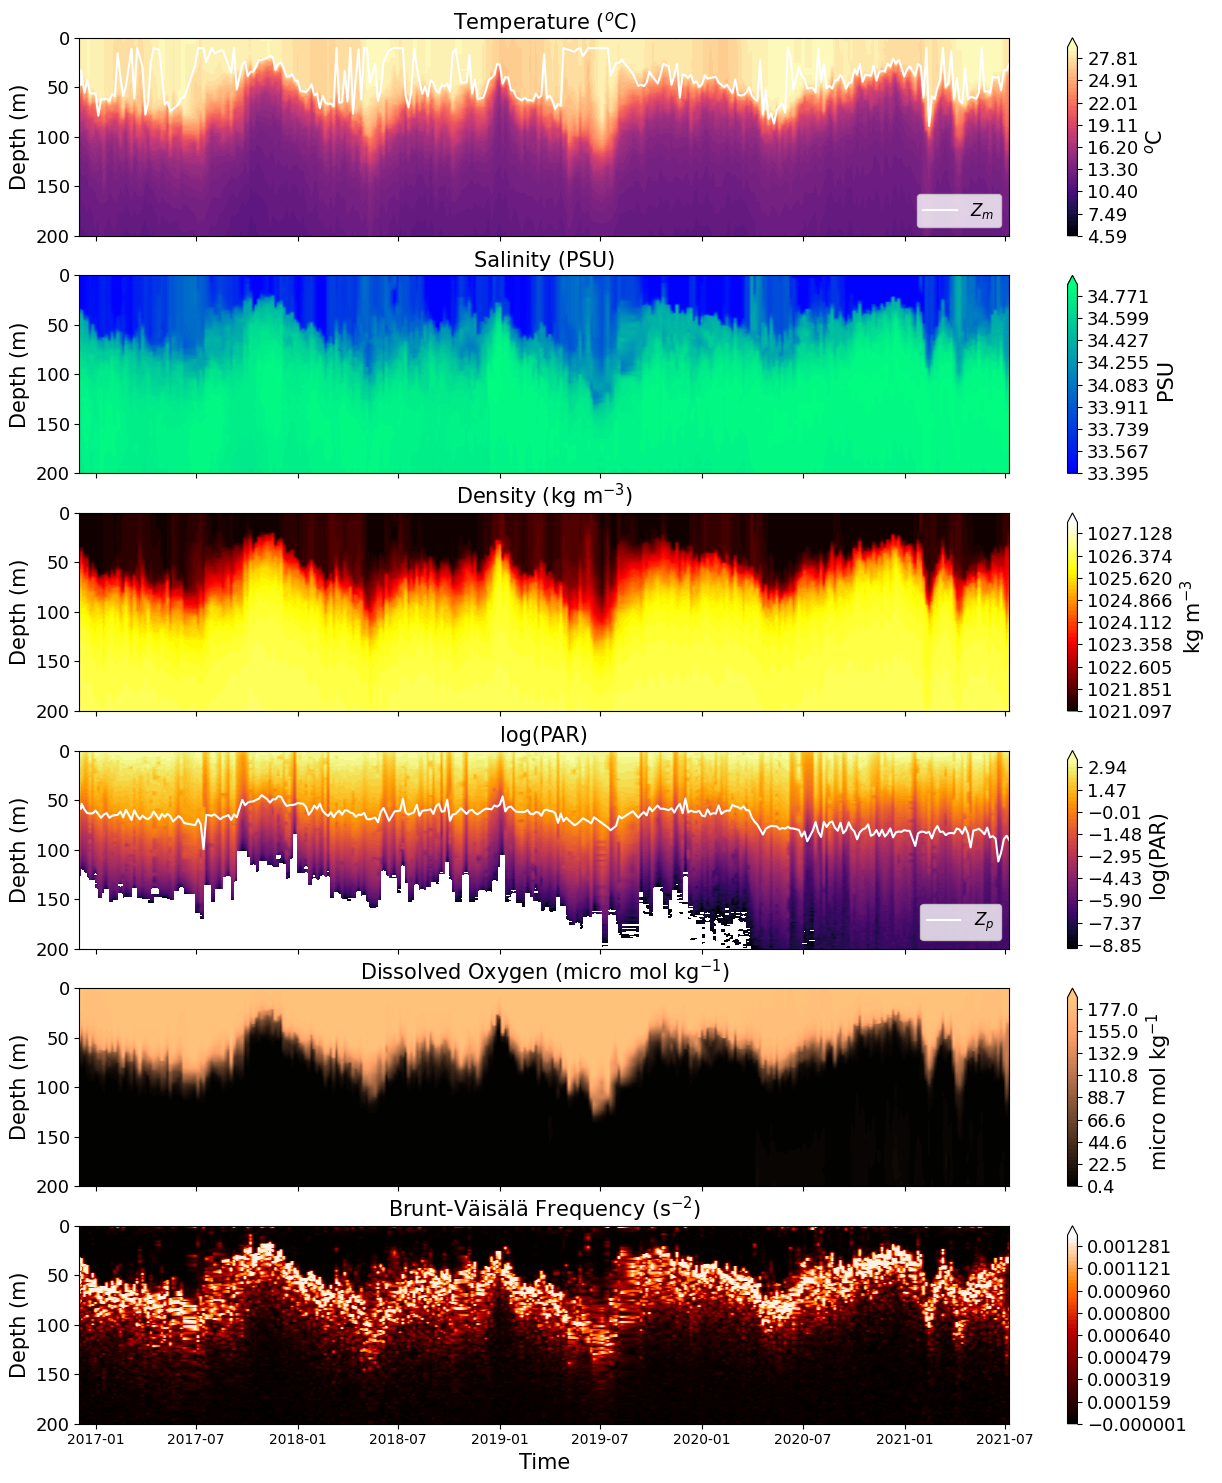

In [13]:
### Figure parameters
TEMP_COL          = mpl.cm.magma  #Temp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
PSAL_COL          = mpl.cm.winter #Salinity colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
DOXY_COL          = mpl.cm.copper #Diss OXY colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
CHLA_COL          = mpl.cm.viridis#Chl-a colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
BBP_COL           = mpl.cm.cividis#bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
PAR_COL           = mpl.cm.inferno
DENS_COL          = mpl.cm.hot
BVF_COL           = mpl.cm.gist_heat
XSIZE             = 15            #Define the xsize of the figure window
YSIZE             = 18            #Define the ysize of the figure window
Title_font_size   = 15            #Define the font size of the titles
Label_font_size_x = 11            #Define the font size of the x-labels
Label_font_size_y = 13            #Define the font size of the y-labels
Cbar_title_size   = 15            #Define the font size of the Colourbar title
Cbar_label_size   = 13            #Define the font size of the Colourbar labels
Percentiles_upper = 99            #Upper percentiles used to constrain the colour scale
Percentiles_lower = 1             #Upper percentiles used to constrain the colour scale

#Define the figure window including 5 subplots orientated vertically
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, figsize=(XSIZE,YSIZE), \
    gridspec_kw={'hspace': 0.2})
fig.patch.set_facecolor('White')

#SUBPLOT 1: TEMPERATURE TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = TEMP_INT
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im1            = ax1.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels,cmap = TEMP_COL, extend="max")
##Set axis info and titles
ax1.set_ylim([200,0]) 
ax1.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax1.set_title('Temperature ($^o$C)', fontsize = Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax1.plot(TIME_BGC,MLD_TEMP_ARRAY, color = 'w', label = '$Z_m$', linewidth = 1.5)
ax1.legend(loc="lower right", fontsize=12)
##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params()
cbar1.set_label("$^o$C", size  = Cbar_title_size)
cbar1.ax.tick_params(labelsize = Cbar_label_size)

#SUBPLOT 2: SALINITY TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = PSAL_INT
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im2 = ax2.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = PSAL_COL, extend="max")
##Set axis info and titles
ax2.set_ylim([200,0]) 
ax2.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax2.set_title('Salinity (PSU)', fontsize= Title_font_size, color='k')
ax2.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params()
cbar2.set_label("PSU", size    = Cbar_title_size)
cbar2.ax.tick_params(labelsize = Cbar_label_size)

#SUBPLOT 3: DENSITY TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = DENS_INT
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im3 = ax3.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = DENS_COL, extend="max")
##Set axis info and titles
ax3.set_ylim([200,0]) 
ax3.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax3.set_title('Density (kg m$^{-3}$)', fontsize= Title_font_size, color='k')
ax3.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar3 = fig.colorbar(im3, ax=ax3)
cbar3.ax.locator_params()
cbar3.set_label("kg m$^{-3}$", size    = Cbar_title_size)
cbar3.ax.tick_params(labelsize = Cbar_label_size)

#SUBPLOT 4: PAR TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = np.log(PAR_INT)
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im4 = ax4.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = PAR_COL, extend="max")
##Set axis info and titles
ax4.set_ylim([200,0]) 
ax4.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax4.set_title('log(PAR)', fontsize= Title_font_size, color='k')
ax4.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax4.plot(TIME_BGC,Zp, color = 'w', label = '$Z_p$', linewidth = 1.5)
ax4.legend(loc="lower right", fontsize=12)
##Add colourbar
cbar4 = fig.colorbar(im4, ax=ax4)
cbar4.ax.locator_params()
cbar4.set_label("log(PAR)", size    = Cbar_title_size)
cbar4.ax.tick_params(labelsize = Cbar_label_size)

#SUBPLOT 5: DISSOLVED OXYGEN TIME-SERIES
#Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = DISS_OXY_INT
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im5 = ax5.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels,cmap = DOXY_COL, extend="max")
##Set axis info and titles
ax5.set_ylim([200,0]) 
ax5.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax5.set_title('Dissolved Oxygen (micro mol kg$^{-1}$)', fontsize= Title_font_size, color='k')
ax5.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar5 = fig.colorbar(im5, ax=ax5)
cbar5.ax.locator_params()
cbar5.set_label("micro mol kg$^{-1}$", size= Cbar_title_size)
cbar5.ax.tick_params(labelsize= Cbar_label_size)

#SUBPLOT 6: BVFTIME-SERIES
#Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BVF_INT
PCT_1          = np.nanpercentile(IN_DATA, Percentiles_lower)
PCT_2          = np.nanpercentile(IN_DATA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im6 = ax6.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels,cmap = BVF_COL, extend="max")
##Set axis info and titles
ax6.set_ylim([200,0]) 
ax6.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax6.set_title('Brunt-Väisälä Frequency (s$^{-2}$)', fontsize= Title_font_size, color='k')
ax6.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax6.set_xlabel('Time', fontsize=15, color='k')
##Add colourbar
cbar6 = fig.colorbar(im6, ax=ax6)
cbar6.ax.locator_params()
cbar6.set_label(" ", size= Cbar_title_size)
cbar6.ax.tick_params(labelsize= Cbar_label_size)
plt.show()

## Viewing Chl-a output of fit (Figure 3 of the paper)

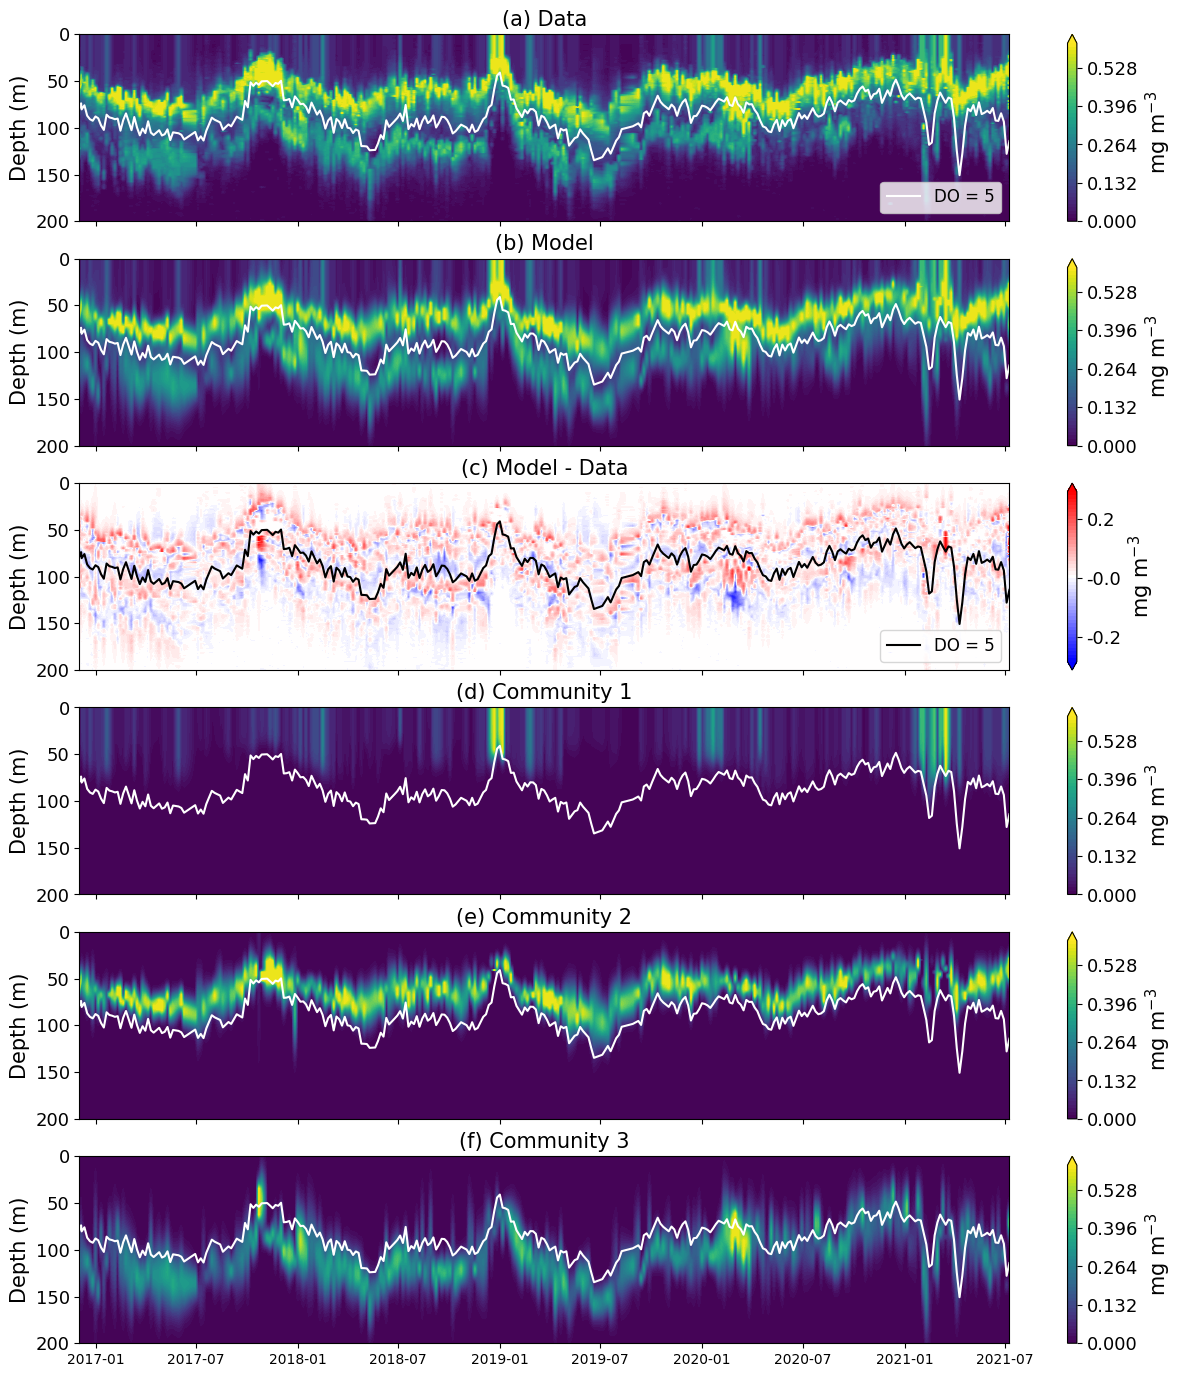

In [14]:
#Figure parameters 
CHLA_COL          = mpl.cm.viridis#Chl-a colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
DIFF_COL          = mpl.cm.bwr#bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
XSIZE             = 15            #Define the xsize of the figure window
YSIZE             = 17            #Define the ysize of the figure window
Title_font_size   = 15            #Define the font size of the titles
Label_font_size_x = 11            #Define the font size of the x-labels
Label_font_size_y = 13            #Define the font size of the y-labels
Cbar_title_size   = 15            #Define the font size of the Colourbar title
Cbar_label_size   = 13            #Define the font size of the Colourbar labels

#Define the figure window including 5 subplots orientated vertically
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, figsize=(XSIZE,YSIZE), \
    gridspec_kw={'hspace': 0.2})
fig.patch.set_facecolor('White')

#SUBPLOT 1: CHLOROPHYLL-A TIME-SERIES
##Set any CHl-a data below 0.001 to 0.001 (minimim detectable limit)
valid          = (CHLA_INT < 0.001).nonzero()
CHLA_INT[valid]= 0.001
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT
PCT_1          = 0.0
PCT_2          = 0.6
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im1 = ax1.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = CHLA_COL, extend="max")
##Set axis info and titles
ax1.plot(TIME_BGC,DOXY_1_DEPTH, color = 'w', label = 'DO = 5')
ax1.set_ylim([200,0]) 
ax1.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax1.set_title('(a) Data', fontsize= Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar1.ax.tick_params(labelsize = Cbar_label_size)
cbar1.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
ax1.legend(loc="lower right", fontsize=12)

#SUBPLOT 2: CHLOROPHYLL-A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT_SIM
PCT_1          = 0.0
PCT_2          = 0.6
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im2          = ax2.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = CHLA_COL, extend="max")
##Set axis info and titles
ax2.set_ylim([200,0]) 
ax2.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax2.set_title('(b) Model', fontsize= Title_font_size, color='k')
ax2.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax2.plot(TIME_BGC,DOXY_1_DEPTH, color = 'w', label = 'DO = 5')
##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar2.ax.tick_params(labelsize = Cbar_label_size)
cbar2.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 3: Difference
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT_SIM - CHLA_INT
PCT_1          = -0.3
PCT_2          = 0.3
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(-0.3, 0.3, 50)
im3          = ax3.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = DIFF_COL, extend="both")
##Set axis info and titles
##Set axis info and titles
ax3.set_ylim([200,0]) 
ax3.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax3.set_title('(c) Model - Data', fontsize= Title_font_size, color='k')
ax3.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax3.plot(TIME_BGC,DOXY_1_DEPTH, color = 'black', label = 'DO = 5')
##Add colourbar
cbar3 = fig.colorbar(im3, ax=ax3)
cbar3.ax.locator_params(nbins=3)
cbar3.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar3.ax.tick_params(labelsize = Cbar_label_size)
cbar3.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
# cbar3.ax.yaxis.set_major_locator(tick.MultipleLocator(0.3))
ax3.legend(loc="lower right", fontsize=12)

#SUBPLOT 4: CHLOROPHYLL-A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT_MLCO
PCT_1          = 0.0
PCT_2          = 0.6
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im4          = ax4.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = CHLA_COL, extend="max")
##Set axis info and titles
ax4.set_ylim([200,0]) 
ax4.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax4.set_title('(d) Community 1', fontsize= Title_font_size, color='k')
ax4.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax4.plot(TIME_BGC,DOXY_1_DEPTH, color = 'w', label = 'DO = 5')
##Add colourbar
cbar4 = fig.colorbar(im4, ax=ax4)
cbar4.ax.locator_params(nbins=5)
cbar4.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar4.ax.tick_params(labelsize = Cbar_label_size)
cbar4.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 5: CHLOROPHYLL-A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT_DCM1
PCT_1          = 0.0
PCT_2          = 0.6
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im5          = ax5.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = CHLA_COL, extend="max")
##Set axis info and titles
ax5.set_ylim([200,0]) 
ax5.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax5.set_title('(e) Community 2', fontsize= Title_font_size, color='k')
ax5.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax5.plot(TIME_BGC,DOXY_1_DEPTH, color = 'w', label = 'DO = 5')
##Add colourbar
cbar5 = fig.colorbar(im5, ax=ax5)
cbar5.ax.locator_params(nbins=5)
cbar5.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar5.ax.tick_params(labelsize = Cbar_label_size)
cbar5.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 6: CHLOROPHYLL-A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_INT_DCM2
PCT_1          = 0.0
PCT_2          = 0.6
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im6          = ax6.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = CHLA_COL, extend="max")
##Set axis info and titles
ax6.set_ylim([200,0]) 
ax6.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax6.set_title('(f) Community 3', fontsize= Title_font_size, color='k')
ax6.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax6.plot(TIME_BGC,DOXY_1_DEPTH, color = 'w', label = 'DO = 5')
##Add colourbar
cbar6 = fig.colorbar(im6, ax=ax6)
cbar6.ax.locator_params(nbins=5)
cbar6.set_label("mg m$^{-3}$", size = Cbar_title_size)
cbar6.ax.tick_params(labelsize = Cbar_label_size)
cbar6.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
plt.show()

## Viewing backscattering output of fit (Supplementary Figure)

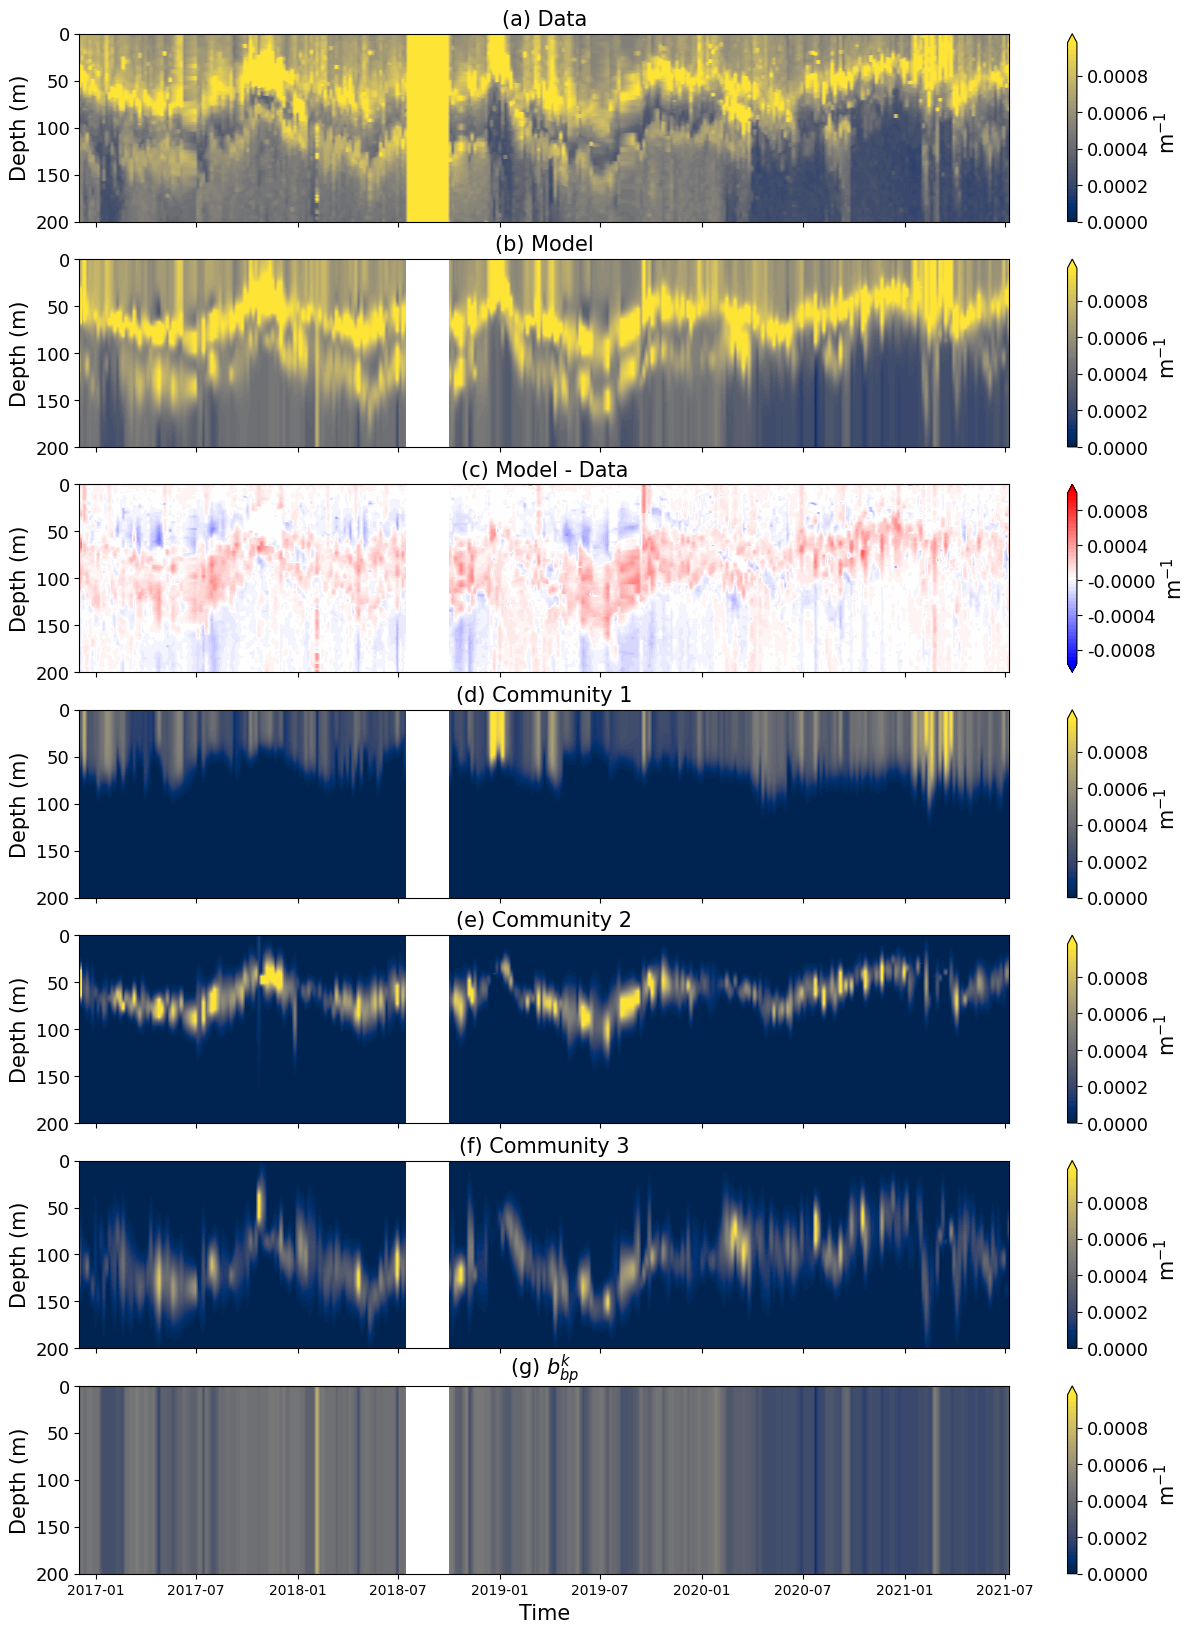

In [15]:
#Figure parameters that can be changed 
BBP_COL           = mpl.cm.cividis#bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
DIFF_COL          = mpl.cm.bwr    #bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
XSIZE             = 15            #Define the xsize of the figure window
YSIZE             = 20            #Define the ysize of the figure window
Title_font_size   = 15            #Define the font size of the titles
Label_font_size_x = 11            #Define the font size of the x-labels
Label_font_size_y = 13            #Define the font size of the y-labels
Cbar_title_size   = 15            #Define the font size of the Colourbar title
Cbar_label_size   = 13            #Define the font size of the Colourbar labels

#Define the figure window including 5 subplots orientated vertically
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, figsize=(XSIZE,YSIZE), \
    gridspec_kw={'hspace': 0.2})
fig.patch.set_facecolor('White')
#SUBPLOT 1: CHLOROPHYLL-A TIME-SERIES
##Set any CHl-a data below 0.001 to 0.001 (minimim detectable limit)
IN_DATA        = BBP_INT
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im1 = ax1.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax1.set_ylim([200,0]) 
ax1.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax1.set_title('(a) Data', fontsize= Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("m$^{-1}$", size = Cbar_title_size)
cbar1.ax.tick_params(labelsize = Cbar_label_size)
cbar1.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 2: CHLOROPHYLL-A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_SIM
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im2          = ax2.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax2.set_ylim([200,0]) 
ax2.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax2.set_title('(b) Model', fontsize= Title_font_size, color='k')
ax2.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("m$^{-1}$", size = Cbar_title_size)
cbar2.ax.tick_params(labelsize = Cbar_label_size)
cbar2.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 3: Difference
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_SIM - BBP_INT
PCT_1          = -0.001
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im3          = ax3.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = DIFF_COL, extend="both")
##Set axis info and titles
ax3.set_ylim([200,0]) 
ax3.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax3.set_title('(c) Model - Data', fontsize= Title_font_size, color='k')
ax3.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar3 = fig.colorbar(im3, ax=ax3)
cbar3.ax.locator_params(nbins=5)
cbar3.set_label("m$^{-1}$", size = Cbar_title_size)
cbar3.ax.tick_params(labelsize = Cbar_label_size)
cbar3.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 4: CHLOROPHYLL-A TIME-SERIES Surface
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_MLCO
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im4          = ax4.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax4.set_ylim([200,0]) 
ax4.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax4.set_title('(d) Community 1', fontsize= Title_font_size, color='k')
ax4.yaxis.set_tick_params(labelsize= Label_font_size_y)
##Add colourbar
cbar4 = fig.colorbar(im4, ax=ax4)
cbar4.ax.locator_params(nbins=5)
cbar4.set_label("m$^{-1}$", size = Cbar_title_size)
cbar4.ax.tick_params(labelsize = Cbar_label_size)
cbar4.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 2: CHLOROPHYLL-A TIME-SERIES Surface
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_DCM1
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im5          = ax5.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax5.set_ylim([200,0]) 
ax5.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax5.set_title('(e) Community 2', fontsize= Title_font_size, color='k')
ax5.yaxis.set_tick_params(labelsize= Label_font_size_y)
#ax5.set_xlabel('Time', fontsize=15, color='k')
##Add colourbar
cbar5 = fig.colorbar(im5, ax=ax5)
cbar5.ax.locator_params(nbins=5)
cbar5.set_label("m$^{-1}$", size = Cbar_title_size)
cbar5.ax.tick_params(labelsize = Cbar_label_size)
cbar5.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 2: CHLOROPHYLL-A TIME-SERIES Surface
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_DCM2
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im6          = ax6.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax6.set_ylim([200,0]) 
ax6.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax6.set_title('(f) Community 3', fontsize= Title_font_size, color='k')
ax6.yaxis.set_tick_params(labelsize= Label_font_size_y)
#ax5.set_xlabel('Time', fontsize=15, color='k')
##Add colourbar
cbar6 = fig.colorbar(im6, ax=ax6)
cbar6.ax.locator_params(nbins=5)
cbar6.set_label("m$^{-1}$", size = Cbar_title_size)
cbar6.ax.tick_params(labelsize = Cbar_label_size)
cbar6.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

#SUBPLOT 2: CHLOROPHYLL-A TIME-SERIES Surface
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = BBP_INT_BBK
PCT_1          = 0.0
PCT_2          = 0.001
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im7          = ax7.contourf(TIME_BGC_MATRIX_INT, DEPTH_INT, IN_DATA, levels, cmap = BBP_COL, extend="max")
##Set axis info and titles
ax7.set_ylim([200,0]) 
ax7.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax7.set_title('(g) $b^k_{bp}$', fontsize= Title_font_size, color='k')
ax7.yaxis.set_tick_params(labelsize= Label_font_size_y)
ax7.set_xlabel('Time', fontsize=15, color='k')
##Add colourbar
cbar7 = fig.colorbar(im7, ax=ax7)
cbar7.ax.locator_params(nbins=5)
cbar7.set_label("m$^{-1}$", size = Cbar_title_size)
cbar7.ax.tick_params(labelsize = Cbar_label_size)
cbar7.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.4f'))

plt.show()

# Compute contributions to integrated Chlorophyll-a and bbp (Figure 5 of the paper)

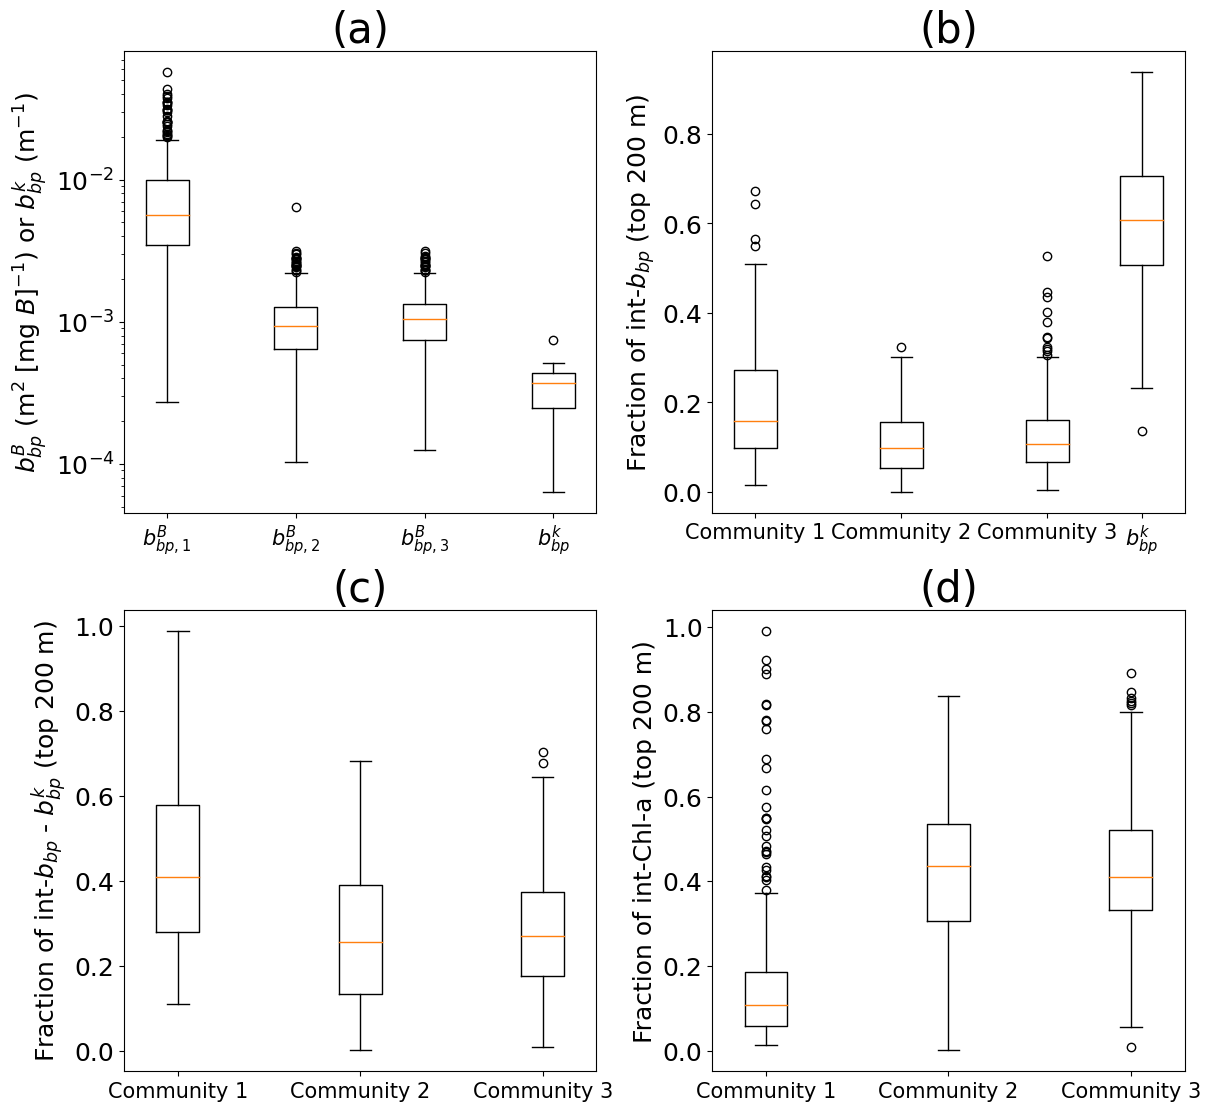

In [16]:
#Define intergration variables
int_chl_total = np.empty(len(JULD))*nan
int_chl_com1  = np.empty(len(JULD))*nan
int_chl_com2  = np.empty(len(JULD))*nan
int_chl_com3  = np.empty(len(JULD))*nan
int_bbp_total = np.empty(len(JULD))*nan
int_bbp_com1  = np.empty(len(JULD))*nan
int_bbp_com2  = np.empty(len(JULD))*nan
int_bbp_com3  = np.empty(len(JULD))*nan
int_bbp_bbpk  = np.empty(len(JULD))*nan
int_PAR       = np.empty(len(JULD))*nan

#Loop through profiles and intergrate
for i in range(len(JULD)):
    # Extract data
    Depth      = DEPTH_INT[i,:]
    Chl_T_SIM  = CHLA_INT_SIM[i,:]
    Chl_T_COM1 = CHLA_INT_MLCO[i,:]
    Chl_T_COM2 = CHLA_INT_DCM1[i,:]
    Chl_T_COM3 = CHLA_INT_DCM2[i,:]
    bbp_T_SIM  = BBP_INT_SIM[i,:]
    bbp_T_COM1 = BBP_INT_MLCO[i,:]
    bbp_T_COM2 = BBP_INT_DCM1[i,:]
    bbp_T_COM3 = BBP_INT_DCM2[i,:]
    bbp_T_bbpk = BBP_INT_BBK[i,:]
    PAR_TT     = PAR_INT[i,:]
    #Select on top 200m 
    asd = np.where(Depth <= 200)
    int_chl_total[i] = spi.trapz(Chl_T_SIM[asd],Depth[asd])
    int_chl_com1[i]  = spi.trapz(Chl_T_COM1[asd],Depth[asd])
    int_chl_com2[i]  = spi.trapz(Chl_T_COM2[asd],Depth[asd])
    int_chl_com3[i]  = spi.trapz(Chl_T_COM3[asd],Depth[asd])
    int_bbp_total[i] = spi.trapz(bbp_T_SIM[asd],Depth[asd])
    int_bbp_com1[i]  = spi.trapz(bbp_T_COM1[asd],Depth[asd])
    int_bbp_com2[i]  = spi.trapz(bbp_T_COM2[asd],Depth[asd])
    int_bbp_com3[i]  = spi.trapz(bbp_T_COM3[asd],Depth[asd])
    int_bbp_bbpk[i]  = spi.trapz(bbp_T_bbpk[asd],Depth[asd])
    int_PAR[i]       = spi.trapz(PAR_TT[asd],Depth[asd])

#Set plot up
fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2,2, figsize=(12,11), constrained_layout=True)
fig.patch.set_facecolor('White')

#Backscattering parameters
DATA1 = bbpS1_ARRAY
DATA2 = bbpS2_ARRAY
DATA3 = bbpS3_ARRAY
DATA4 = bbpk_ARRAY
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ind = np.where(DATA4 >= 0)
DATA4 = DATA4[ind]
ax1.boxplot(DATA1, positions = [-2.0], widths = 0.5)
ax1.boxplot(DATA2, positions = [-0.5], widths = 0.5)
ax1.boxplot(DATA3, positions = [1.0], widths = 0.5)
ax1.boxplot(DATA4, positions = [2.5], widths = 0.5)
ax1.set_yscale('log')
ax1.set_xticklabels(['$b^B_{bp,1}$','$b^B_{bp,2}$','$b^B_{bp,3}$','$b^k_{bp}$'], fontsize = 15)
ax1.set_ylabel('$b^B_{bp}$ (m$^2$ [mg $B$]$^{-1}$) or $b^k_{bp}$ (m$^{-1}$)', fontsize = 18) 
ax1.tick_params(axis='x', labelsize= 15)
ax1.tick_params(axis='y', labelsize= 18)
ax1.set_title('(a)', fontsize=30, color='k')

#Contribution to integrated total bbp 
DATA1 = int_bbp_com1 / int_bbp_total
DATA2 = int_bbp_com2 / int_bbp_total
DATA3 = int_bbp_com3 / int_bbp_total
DATA4 = int_bbp_bbpk / int_bbp_total
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ind = np.where(DATA4 >= 0)
DATA4 = DATA4[ind]
#Backscattering
ax2.boxplot(DATA1, positions = [-2.0], widths = 0.5)
ax2.boxplot(DATA2, positions = [-0.3], widths = 0.5)
ax2.boxplot(DATA3, positions = [1.4], widths = 0.5)
ax2.boxplot(DATA4, positions = [2.5], widths = 0.5)
ax2.set_xticklabels(['Community 1','Community 2','Community 3','$b^k_{bp}$'], fontsize = 15)
ax2.set_ylabel('Fraction of int-$b_{bp}$ (top 200 m)', fontsize = 18) 
ax2.tick_params(axis='x', labelsize= 15)
ax2.tick_params(axis='y', labelsize= 18)
ax2.set_title('(b)', fontsize=30, color='k')

#Contribution to integrated total bbp minus bbpk
DATA1 = int_bbp_com1 / (int_bbp_com1+int_bbp_com2+int_bbp_com3)
DATA2 = int_bbp_com2 / (int_bbp_com1+int_bbp_com2+int_bbp_com3)
DATA3 = int_bbp_com3 / (int_bbp_com1+int_bbp_com2+int_bbp_com3)
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
#Chl
ax3.boxplot(DATA1, positions = [-1.7], widths = 0.4)
ax3.boxplot(DATA2, positions = [0.0], widths = 0.4)
ax3.boxplot(DATA3, positions = [1.7], widths = 0.4)
ax3.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 15)
ax3.set_ylabel('Fraction of int-$b_{bp}$ - $b^k_{bp}$ (top 200 m)', fontsize = 18) 
ax3.tick_params(axis='x', labelsize= 15)
ax3.tick_params(axis='y', labelsize= 18)
ax3.set_title('(c)', fontsize=30, color='k')

#Contribution to integrated Chlorophyll-a
DATA1 = int_chl_com1 / int_chl_total
DATA2 = int_chl_com2 / int_chl_total
DATA3 = int_chl_com3 / int_chl_total
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
#Chl
ax4.boxplot(DATA1, positions = [-1.7], widths = 0.4)
ax4.boxplot(DATA2, positions = [0.0], widths = 0.4)
ax4.boxplot(DATA3, positions = [1.7], widths = 0.4)
ax4.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 15)
ax4.set_ylabel('Fraction of int-Chl-a (top 200 m)', fontsize = 18) 
ax4.tick_params(axis='x', labelsize= 15)
ax4.tick_params(axis='y', labelsize= 18)
ax4.set_title('(d)', fontsize=30, color='k')

plt.show()

# Extract enviromental data at depth of communities (Figure 6 of the paper)

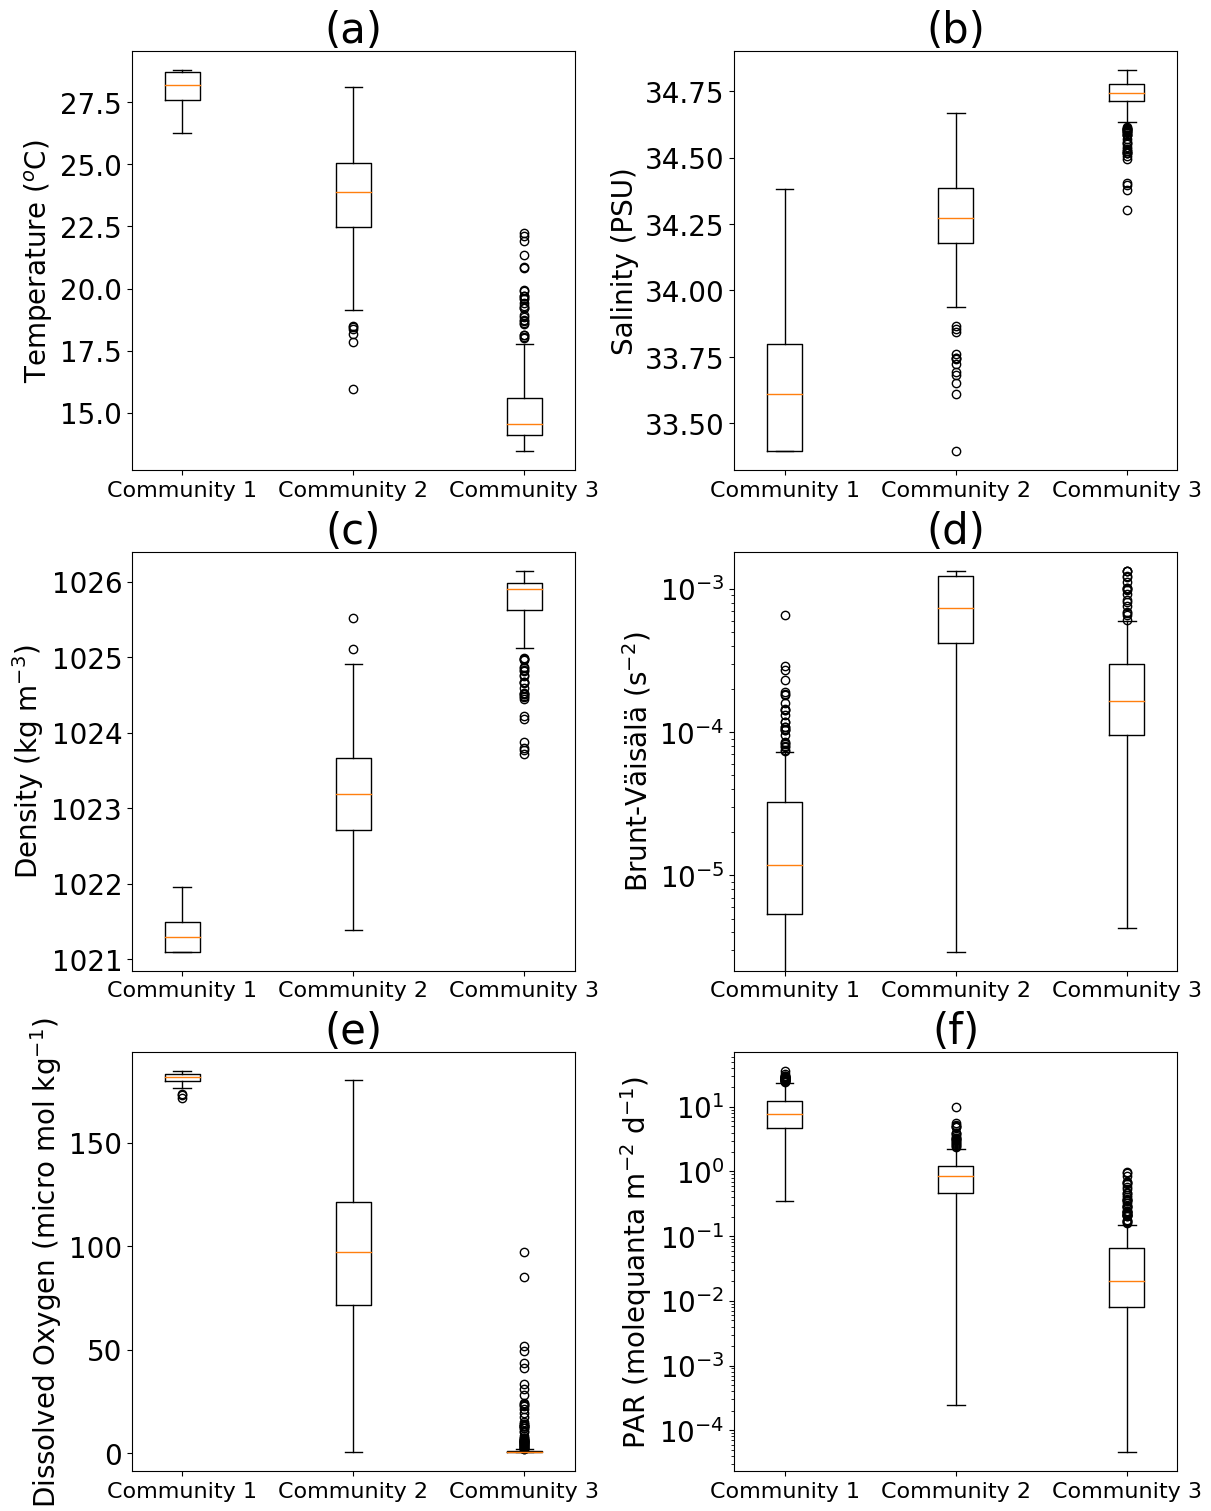

In [17]:
#Define variables
temp_com1     = np.empty(len(JULD))*nan
temp_com2     = np.empty(len(JULD))*nan
temp_com3     = np.empty(len(JULD))*nan
sal_com1      = np.empty(len(JULD))*nan
sal_com2      = np.empty(len(JULD))*nan
sal_com3      = np.empty(len(JULD))*nan
dens_com1     = np.empty(len(JULD))*nan
dens_com2     = np.empty(len(JULD))*nan
dens_com3     = np.empty(len(JULD))*nan
bvf_com1      = np.empty(len(JULD))*nan
bvf_com2      = np.empty(len(JULD))*nan
bvf_com3      = np.empty(len(JULD))*nan
oxy_com1      = np.empty(len(JULD))*nan
oxy_com2      = np.empty(len(JULD))*nan
oxy_com3      = np.empty(len(JULD))*nan
light_com1    = np.empty(len(JULD))*nan
light_com2    = np.empty(len(JULD))*nan
light_com3    = np.empty(len(JULD))*nan

#Loop through profiles and extract environmental data
for i in range(len(JULD)):
    mld        = MLD_TEMP_ARRAY[i]
    Depth_com2 = TAU2_ARRAY[i]/Kd_fit[i]
    Depth_com3 = TAU3_ARRAY[i]/Kd_fit[i]
    
    Depth  = DEPTH_INT[i,:]
    Tem    = TEMP_INT[i,:]
    sal    = PSAL_INT[i,:]
    dens   = DENS_INT[i,:]
    bru    = BVF_INT[i,:]
    oxy    = DISS_OXY_INT[i,:]
    light  = PAR_INT[i,:]
    
    #Community 1
    idx = np.where(Depth < mld)
    temp_com1[i]  = np.median(Tem[idx])
    sal_com1[i]   = np.median(sal[idx])
    dens_com1[i]  = np.median(dens[idx])
    bvf_com1[i]   = np.median(bru[idx])
    oxy_com1[i]   = np.median(oxy[idx])
    light_com1[i] = np.median(light[idx])

    #Community 2
    if Depth_com2 > 0:
        idx = np.where(np.min(np.abs(Depth_com2-Depth)) == np.abs(Depth_com2-Depth))
        temp_com2[i]  = Tem[idx]
        sal_com2[i]   = sal[idx]
        dens_com2[i]  = dens[idx]
        bvf_com2[i]   = bru[idx]
        oxy_com2[i]   = oxy[idx]
        light_com2[i] = light[idx]
                          
    #Community 3
    if Depth_com3 > 0:
        idx = np.where(np.min(np.abs(Depth_com3-Depth)) == np.abs(Depth_com3-Depth))
        temp_com3[i]  = Tem[idx]
        sal_com3[i]   = sal[idx]
        dens_com3[i]  = dens[idx]
        bvf_com3[i]   = bru[idx]
        oxy_com3[i]   = oxy[idx]
        light_com3[i] = light[idx]
    
#Set plot up
fig, ([ax1, ax2],[ax3, ax4],[ax5, ax6]) = plt.subplots(3,2, figsize=(12,15), constrained_layout=True)
fig.patch.set_facecolor('White')

#Temperature
DATA1 = temp_com1
DATA2 = temp_com2
DATA3 = temp_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax1.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax1.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax1.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax1.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax1.set_ylabel('Temperature ($^o$C)', fontsize = 20) 
ax1.tick_params(axis='x', labelsize= 16)
ax1.tick_params(axis='y', labelsize= 20)
ax1.set_title('(a)', fontsize=30, color='k')

#Salinity
DATA1 = sal_com1
DATA2 = sal_com2
DATA3 = sal_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax2.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax2.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax2.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax2.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax2.set_ylabel('Salinity (PSU)', fontsize = 20) 
ax2.tick_params(axis='x', labelsize= 16)
ax2.tick_params(axis='y', labelsize= 20)
ax2.set_title('(b)', fontsize=30, color='k')

#Density
DATA1 = dens_com1
DATA2 = dens_com2
DATA3 = dens_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax3.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax3.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax3.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax3.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax3.set_ylabel('Density (kg m$^{-3}$)', fontsize = 20) 
ax3.tick_params(axis='x', labelsize= 16)
ax3.tick_params(axis='y', labelsize= 20)
ax3.set_title('(c)', fontsize=30, color='k')

#BRUNT
DATA1 = bvf_com1
DATA2 = bvf_com2
DATA3 = bvf_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax4.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax4.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax4.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax4.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax4.set_ylabel('Brunt-Väisälä (s$^{-2}$)', fontsize = 20) 
ax4.tick_params(axis='x', labelsize= 16)
ax4.tick_params(axis='y', labelsize= 20)
ax4.set_title('(d)', fontsize=30, color='k')
ax4.set_yscale('log')

#DISS OXY
DATA1 = oxy_com1
DATA2 = oxy_com2
DATA3 = oxy_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax5.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax5.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax5.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax5.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax5.set_ylabel('Dissolved Oxygen (micro mol kg$^{-1}$)', fontsize = 20) 
ax5.tick_params(axis='x', labelsize= 16)
ax5.tick_params(axis='y', labelsize= 20)
ax5.set_title('(e)', fontsize=30, color='k')

#PAR
DATA1 = light_com1
DATA2 = light_com2
DATA3 = light_com3
ind = np.where(DATA1 >= 0)
DATA1 = DATA1[ind]
ind = np.where(DATA2 >= 0)
DATA2 = DATA2[ind]
ind = np.where(DATA3 >= 0)
DATA3 = DATA3[ind]
ax6.boxplot(DATA1, positions = [-1.7], widths = 0.35)
ax6.boxplot(DATA2, positions = [0.0], widths = 0.35)
ax6.boxplot(DATA3, positions = [1.7], widths = 0.35)
ax6.set_xticklabels(['Community 1','Community 2','Community 3'], fontsize = 16)
ax6.set_ylabel('PAR (molequanta m$^{-2}$ d$^{-1}$)', fontsize = 20) 
ax6.tick_params(axis='x', labelsize= 16)
ax6.tick_params(axis='y', labelsize= 20)
ax6.set_title('(f)', fontsize=30, color='k')
ax6.set_yscale('log')

plt.show()